# Analysis of matched pairs using ILUAii data

In [112]:
library(tidyverse)
library(vegan)
library(cowplot)
library(MetBrewer)
library(RColorBrewer)

In [113]:
path <- '/exports/csce/datastore/geos/users/s0834538/pa_matching_data/'

In [114]:
##read in the plots and stems from ILUAii data
plots <- read_csv(paste0(path,'iluaii/plots.csv'), show_col_types = FALSE)
stems <- read_csv(paste0(path,'iluaii/stems.csv'), show_col_types = FALSE)

In [115]:
##read in match data 
psm <- read_csv('data/PSM_matched_data.csv', show_col_types = FALSE) %>% mutate(dataset = 'PSM_clpr')
psm2 <- read_csv('data/PSM_no_clpr_matched_data.csv', show_col_types = FALSE) %>% mutate(dataset = 'PSM')
mdm <- read_csv('data/MDM_matched_data.csv', show_col_types = FALSE) %>% mutate(dataset = 'MDM_clpr')
mdm2 <- read_csv('data/MDM_no_clpr_matched_data.csv', show_col_types = FALSE) %>% mutate(dataset = 'MDM')
unm <- read_csv('data/unmatched_data_clusters.csv', show_col_types = FALSE) %>% mutate(dataset = 'Unmatched') %>% 
            drop_na() 

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1



In [116]:
table(unm$treatment)


  0   1 
599 323 

In [117]:
##create 1000 random datasets for comparrison

randoms <- data.frame()

set.seed(123) 

for (i in 1:1000) {
        j = runif(1, 35, 323) #randomly select the nubmer of matched pairs max is total nubmer of treated min is > 10% of max
        df <- unm %>% 
                    group_by(treatment) %>% 
                    sample_n(j) %>%
                    mutate(subclass = seq(1:j)) %>%
                    ungroup() %>% mutate(dataset = paste0('dataset',i))
        randoms <- bind_rows(randoms, df)
}

In [118]:
##calculate plot measures at the cluster scale
clusters <- plots %>% 
                mutate(stocking_ha = n_stems / plot_area) %>%
                select(plot_cluster, stocking_ha, ba_ha, diam_mean) %>%
                group_by(plot_cluster) %>%
                summarize(across(stocking_ha:diam_mean, ~ mean(.x, na.rm = TRUE))) %>%
                mutate(across(everything(), ~replace(., is.na(.), 0))) 

In [119]:
##select only distinct trees from the stems dataset - aovids inflated abudances
trees <- stems %>%
            select(plot_id, tree_id, species_name_clean) %>%
            distinct(tree_id, .keep_all = TRUE)

In [120]:
##make a community matrix
sp_mat <- plots %>%
            select(plot_id, plot_cluster) %>%
            left_join(trees, by = 'plot_id') %>%
            group_by(plot_cluster, species_name_clean) %>%
            summarize(count = length(species_name_clean)) %>%
            ungroup() %>%
            pivot_wider(names_from = 'species_name_clean', values_from = 'count') %>%
            mutate(across(everything(), ~replace(., is.na(.), 0))) %>%
            column_to_rownames(var = "plot_cluster") %>%
            select(-'NA')

`summarise()` has grouped output by 'plot_cluster'. You can override using the `.groups` argument.



In [121]:
##calcualte shannon index
shannon <- diversity(sp_mat, index = "shannon") 

In [122]:
##calcuate richenss as sum of species
richness <- sp_mat %>% 
            rownames_to_column(var = "plot_cluster") %>%
            mutate(across(where(is.numeric), ~replace(., . > 0, 1))) %>%
            transmute(plot_cluster, richness = rowSums(across(where(is.numeric)))) 

In [123]:
##convert to dataframes
shannon_df <- as.data.frame(shannon) %>% 
                rownames_to_column(var = "plot_cluster")

In [124]:
##calculate plot measures of species at the cluster scale
pm_sp <- richness %>%
            left_join(shannon_df, by = 'plot_cluster')

In [125]:
#read in table of high vlaue tree species from Zambia
hv_trees <- read_csv('data/high_value_trees.csv', show_col_types = FALSE)

In [126]:
##filter to jsut those with an extractive use - timber of charcol
hv_extract <- hv_trees %>% 
                filter(str_detect(Major_use, c('Timber','Charcoal')))

In [127]:
##as a list
hve_sp <- hv_extract$Species

In [128]:
##number of high vlaue extractive speceis in a plot
pm_hve_sp <- trees %>%
                filter(species_name_clean %in% hve_sp) %>%
                left_join(select(plots, plot_cluster, plot_id), by = 'plot_id') %>%
                group_by(plot_cluster) %>%
                summarize(hve_sp = length(species_name_clean))

In [129]:
##join all plot measurments together
pm <- clusters %>% 
            left_join(pm_sp, by = 'plot_cluster') %>%
            left_join(pm_hve_sp, by = 'plot_cluster') %>%
            mutate(hve_sp = ifelse(is.na(hve_sp), 0, hve_sp)) 

In [130]:
##mean standerize the plot measurements so mean = 0
pm_stand <- pm %>%
             mutate(across(.cols = stocking_ha:hve_sp, ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)))

In [131]:
##plot distrubtion of plot measurments in treamaent and control
pm_long <- unm %>% 
            select(plot_cluster, treatment) %>%
            left_join(pm_stand, by = 'plot_cluster') %>%
            pivot_longer(stocking_ha:hve_sp, names_to = 'var', values_to = 'value') %>%
            mutate(treatment = as.factor(treatment))

In [164]:
##plot distrubtion of plot measurments in treamaent and control
pm_long_raw <- unm %>% 
            select(plot_cluster, treatment) %>%
            left_join(pm, by = 'plot_cluster') %>%
            pivot_longer(stocking_ha:hve_sp, names_to = 'var', values_to = 'value') %>%
            mutate(treatment = as.factor(treatment), 
                   metric = factor(var, ordered = TRUE, levels = c('richness', 'shannon', 'hve_sp', 'ba_ha', 'diam_mean', 'stocking_ha')))

# How balanced are the matched datasets using plot measurements?

In [132]:
all_pm <-bind_rows(psm, psm2, mdm, mdm2, unm) %>%
            select(dataset, plot_cluster, treatment, subclass) %>%
            left_join(pm, by = 'plot_cluster') 

In [133]:
all_pms <-bind_rows(psm, psm2, mdm, mdm2, unm) %>%
            select(dataset, plot_cluster, treatment, subclass) %>%
            left_join(pm_stand, by = 'plot_cluster') 

In [27]:
##chosoe pallette
pal <- as.list(met.brewer('Archambault'))

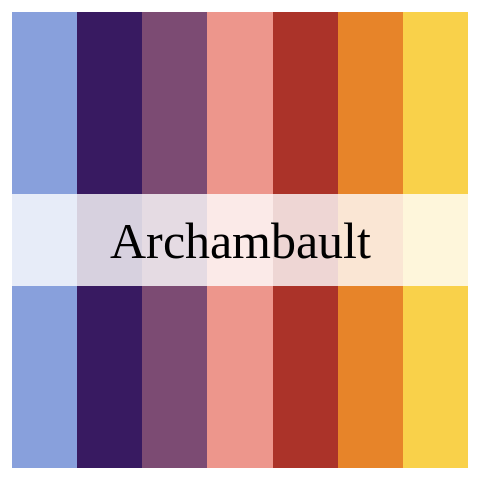

In [28]:
options(repr.plot.width=4, repr.plot.height=4)
met.brewer('Archambault')

In [165]:
# New facet label names for dose variable
metric.labs <- c('Species richness', 'Shannon index', 'High-value trees', 
                                        'Basal area', 'Tree size', 'Stocking density')
names(metric.labs) <- c('richness', 'shannon', 'hve_sp', 'ba_ha', 'diam_mean', 'stocking_ha')

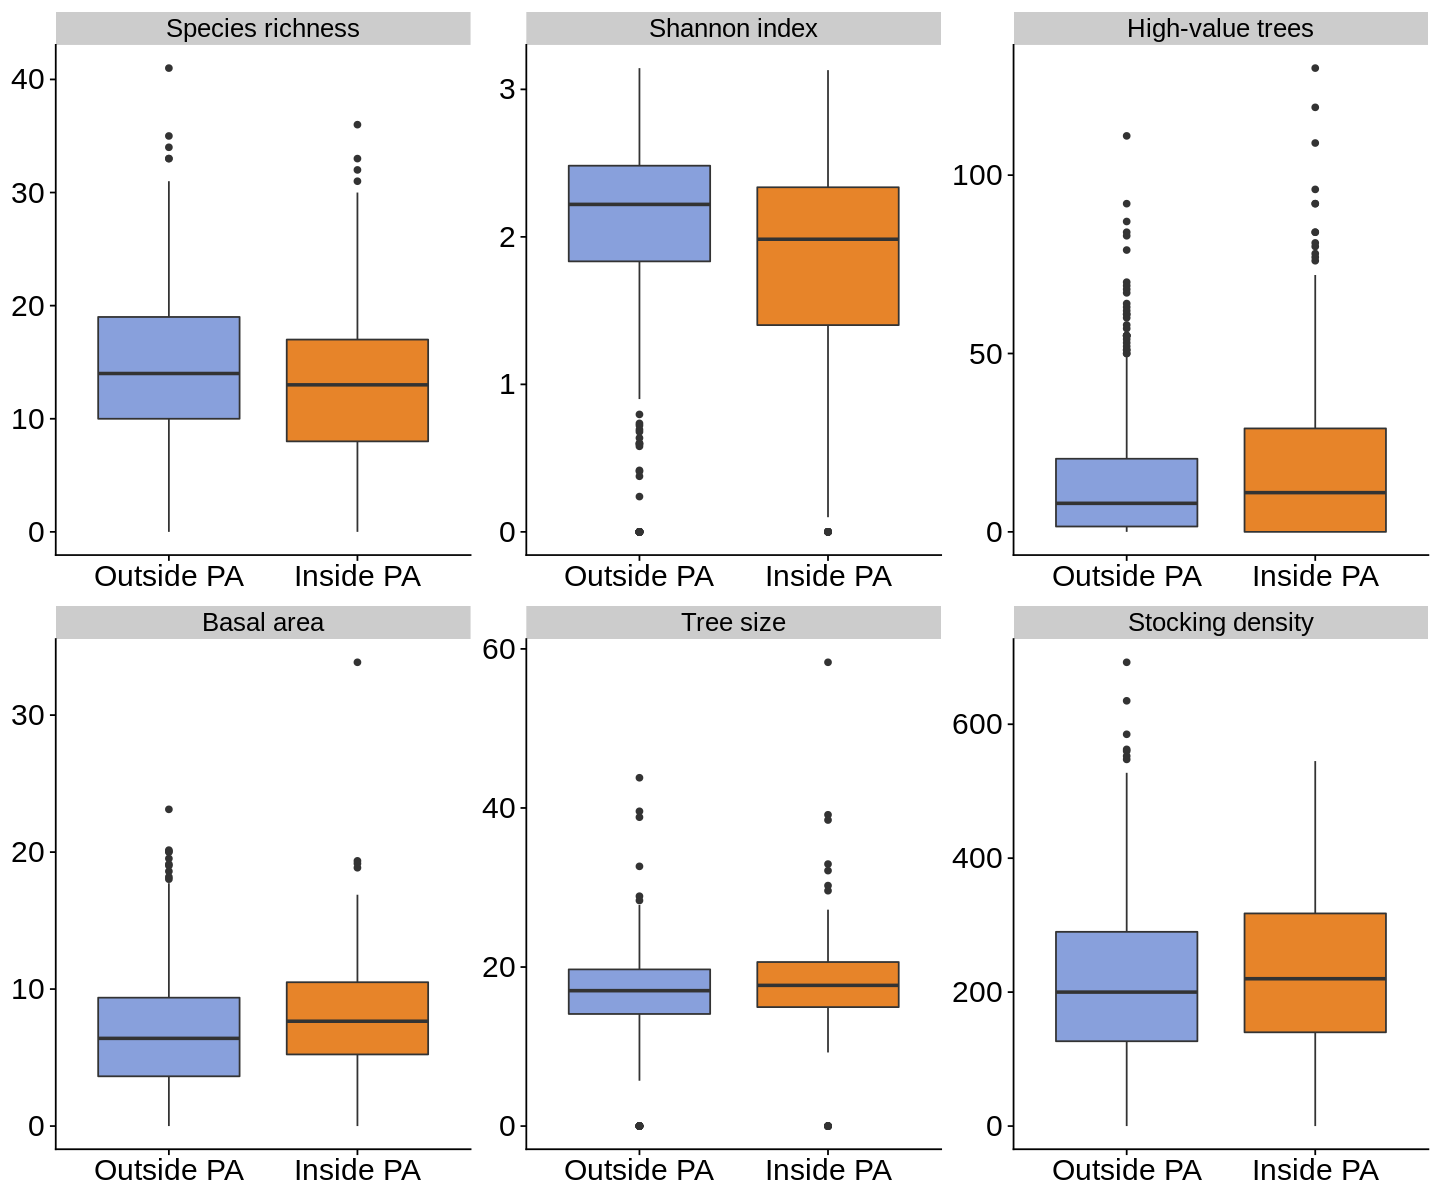

In [167]:
##PLOT OF RAW DATA DIFFERENCES
(unm_bal_plt <- ggplot()+
                #geom_violin(data = pm_long_raw, aes(treatment, value, fill = treatment)) +
                geom_boxplot(data = pm_long_raw, aes(treatment, value, fill = treatment)) +
                facet_wrap(~metric, scales = 'free',  labeller = labeller(metric = metric.labs)) +
                theme_cowplot() +
                scale_fill_manual(values = c(pal[1], pal[6])) +
                scale_x_discrete(labels = c('Outside PA', 'Inside PA')) +
                theme(text = element_text(size = 18),  
                     axis.title =element_blank(), 
                     axis.text=element_text(size = 18),
                     legend.position = 'none')
 )

In [168]:
ggsave(unm_bal_plt, 'png', filename = 'figures/raw_data_bal_plot.png', width = 12, height = 10)

In [23]:
#estamte the sd for treated units (what MathcIT uses as standerization factor for ATT - the default)
metrics = unique(pm_long$var)

trt_sd <- all_pm %>% 
            filter(dataset == 'Unmatched' & treatment == 1) %>% 
                select(all_of(metrics)) %>% 
                    summarize(across(all_of(metrics), ~sd(.x))) %>%
                        pivot_longer(cols = everything(), names_to = 'metric', values_to = 'trt_sd')

In [24]:
##what is the smd for unobervered covarites for each dataset
metrics = unique(pm_long$var)
datasets = unique(all_pm$dataset)

smd_df <- data.frame()

for(i in 1:length(datasets)) {

    data <-  all_pm %>% filter(dataset == datasets[i]) %>%
                              select(treatment, all_of(metrics))
        
        
        ##calcauite SMD for each conf in each dataset
        smd <- data %>%
                 group_by(treatment) %>%
                 summarize(across(all_of(metrics), list(mean = mean, var = var),.names = "{.col}-{.fn}")) %>%
                 ungroup() %>%
    
                 summarize(across(.cols = ends_with('mean'), ~ (last(.x) - first(.x))), 
                           across(.cols = ends_with('var'), ~ (last(.x)/first(.x)))) %>%
                 pivot_longer(cols =  everything(), names_to = c('metric', 'measure'),  names_sep= "-", values_to = 'value') %>%

                 pivot_wider(names_from = 'measure', values_from = 'value') %>%
                 rename('mean_dif' = 'mean', 'var_ratio' = 'var') %>%
                 left_join(trt_sd, by = 'metric') %>%
                 mutate(smd = mean_dif / trt_sd, abs_smd = abs(mean_dif) / trt_sd, dataset = datasets[i])
                 
        smd_mean <- smd %>% 
                      group_by(dataset) %>%
                      summarize(metric = 'mean', across(mean_dif:abs_smd, mean)) %>%
                      select(metric:abs_smd, dataset)  
        
        smd_df = bind_rows(smd_df, smd, smd_mean)
     }   


In [25]:
##convert to an ordered factor for ploting
smd_df <- smd_df %>%
            mutate(metric2 = factor(metric, ordered = TRUE, levels = c('mean', 'richness', 'shannon', 'hve_sp', 'ba_ha', 'diam_mean', 'stocking_ha')))

In [26]:
## calcualte SMD for plot measurments for the randomly generated datasets
smd_ran <- randoms %>%
                select(plot_cluster, dataset, treatment) %>%
                    left_join(pm, by = 'plot_cluster') %>%
                        group_by(dataset, treatment) %>%
                         summarize(across(all_of(metrics), list(mean = mean, var = var),.names = "{.col}-{.fn}")) %>%
                            ungroup() %>%
                             group_by(dataset) %>%
                              summarize(across(.cols = ends_with('mean'), ~ (last(.x) - first(.x))), 
                                         across(.cols = ends_with('var'), ~ (last(.x)/first(.x)))) %>%
                              pivot_longer(cols =  !dataset, names_to = c('metric', 'measure'),  names_sep= "-", values_to = 'value') %>%

                              pivot_wider(names_from = 'measure', values_from = 'value') %>%
                              rename('mean_dif' = 'mean', 'var_ratio' = 'var') %>%

                                 left_join(trt_sd, by = c('metric')) %>%
                                    mutate(smd = mean_dif / trt_sd, abs_smd = abs(mean_dif) / trt_sd)

smd_mean_ran <- smd_ran %>% 
                      group_by(dataset) %>%
                      summarize(metric = 'mean', across(mean_dif:abs_smd, mean))


smd_ran2 <- bind_rows(smd_mean_ran, smd_ran) %>%
            mutate(metric2 = factor(metric, ordered = TRUE, levels = c('mean', 'richness', 'shannon', 'hve_sp', 'ba_ha', 'diam_mean', 'stocking_ha')))

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.



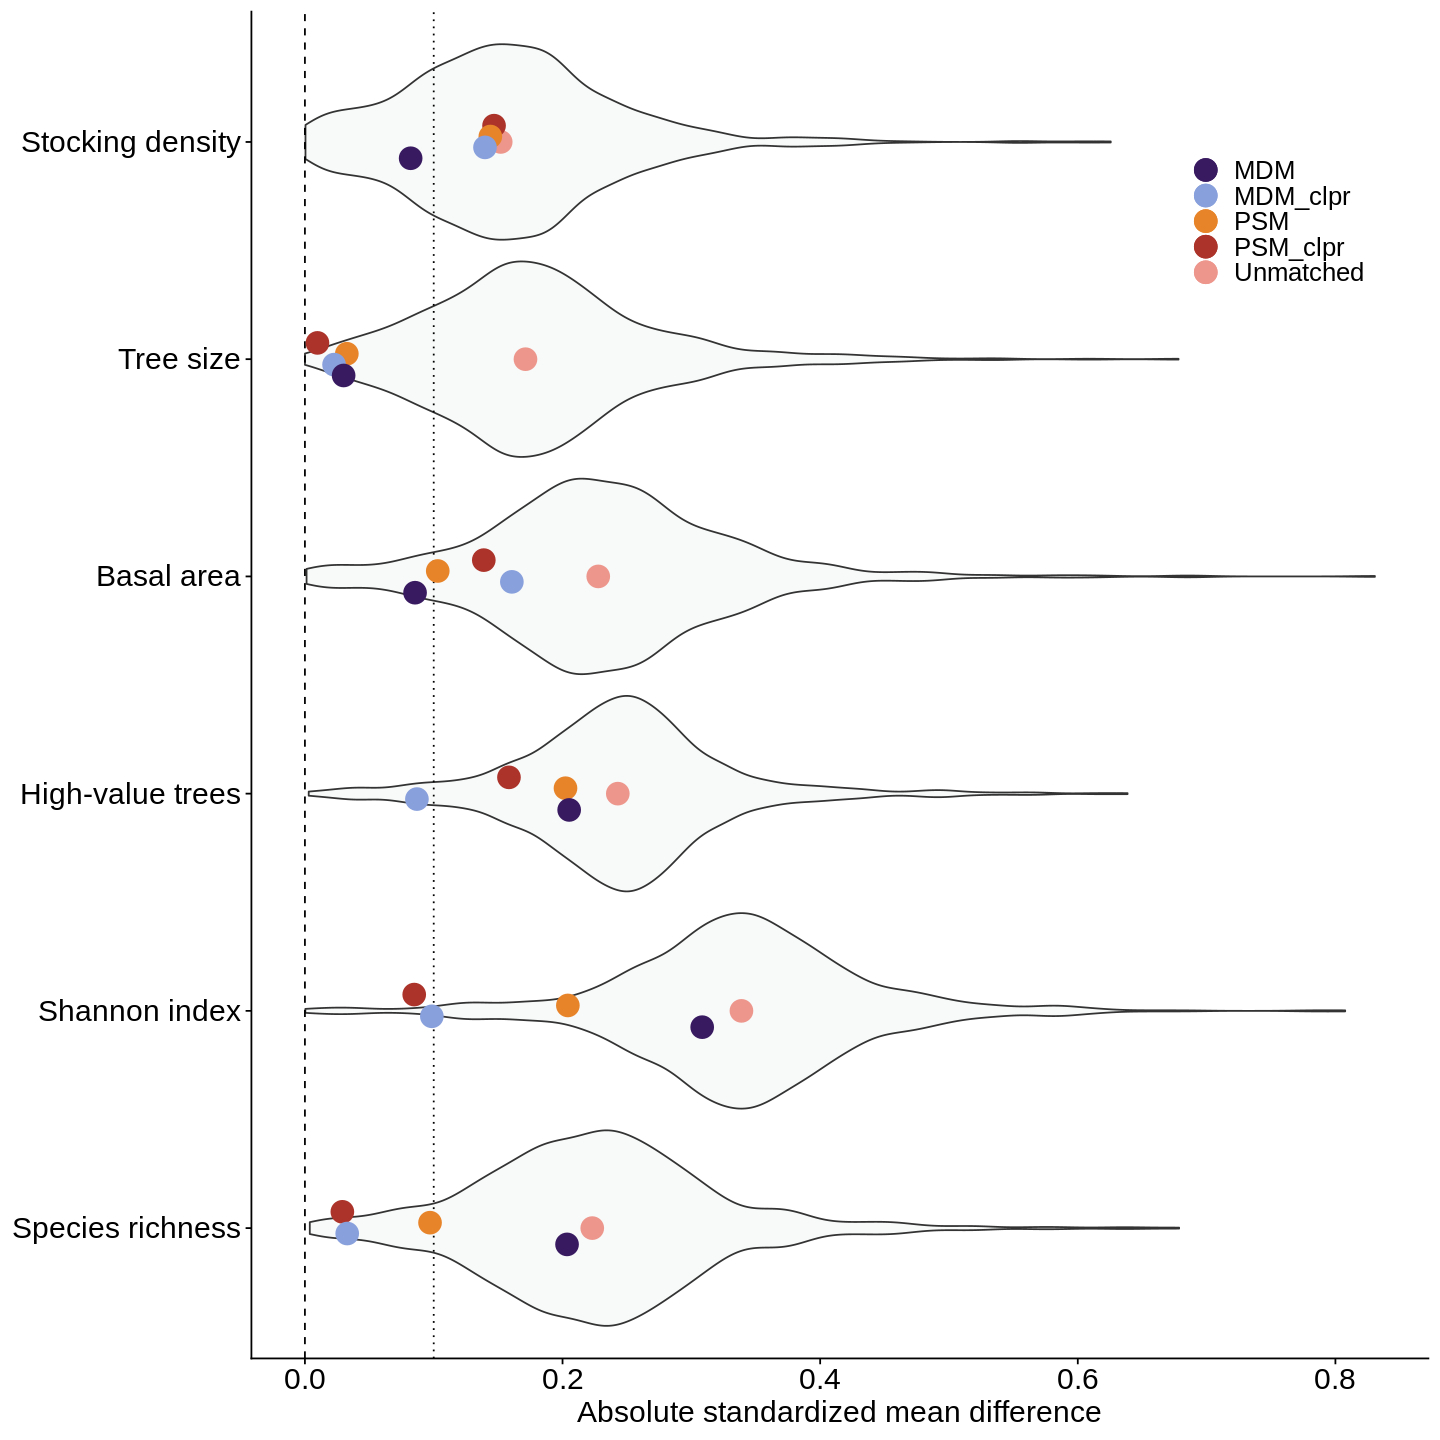

In [29]:
##produce plot of smds for all match years 
##plot ofthe smd for each confounder before and after the match, the 'distacne' measure is the propensity score
options(repr.plot.width=12, repr.plot.height=12)

(smd_plot <- ggplot() + 
            geom_violin(data = filter(smd_ran2, metric != 'mean'), aes(abs_smd, metric2), fill = '#F8F9F9', scale = 'width') +
            geom_vline(xintercept = 0, linetype = 'dashed') +
            geom_vline(xintercept = 0.1, linetype = 'dotted') +
            geom_point(data = filter(smd_df, dataset == 'Unmatched' & metric != 'mean'), aes(x = abs_smd, metric2,  colour = dataset), stroke = 2, size = 4) +
            geom_point(data = filter(smd_df, dataset != 'Unmatched' & metric != 'mean'), aes(x = abs_smd, metric2, colour = dataset), stroke = 2, size = 4,
                       position = position_dodge(width = 0.2)) +
            theme_cowplot() +
            scale_colour_manual(values = c(pal[2], pal[1], pal[6], pal[5], pal[4])) +
            scale_y_discrete(labels = c('Species richness', 'Shannon index', 'High-value trees', 
                                        'Basal area', 'Tree size', 'Stocking density')) +
            labs(x='Absolute standardized mean difference') +
            theme(text = element_text(size = 18),  
                     axis.title.y =element_blank(), 
                     axis.text=element_text(size = 18),
                     legend.position = c(0.8, 0.85), legend.title = element_blank())
)


In [30]:
ggsave(smd_plot, 'png', filename = 'figures/smd_plot_unob.png', width = 12, height = 10)

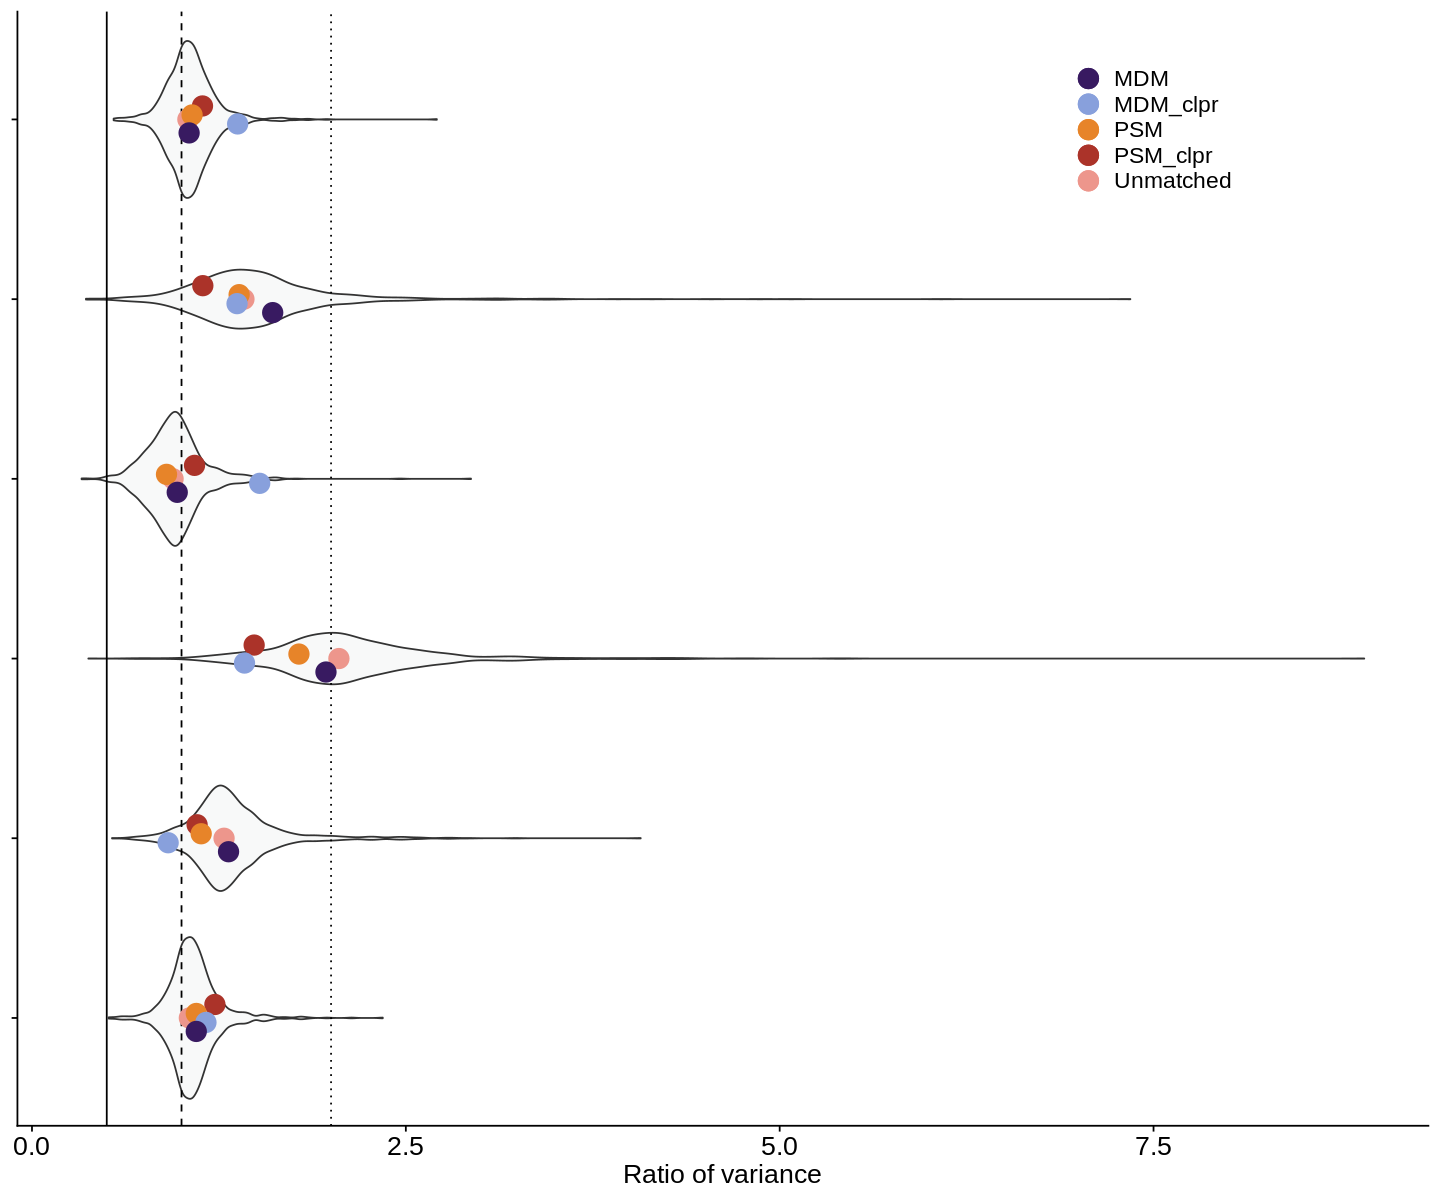

In [31]:
##produce plot of smds for all match years 
##plot ofthe smd for each confounder before and after the match, the 'distacne' measure is the propensity score
options(repr.plot.width=12, repr.plot.height=10)

(rvar_plot <- ggplot() + 
            geom_violin(data = filter(smd_ran2, metric != 'mean'), aes(var_ratio, metric2), fill = '#F8F9F9') +
            geom_vline(xintercept = 0.5) + 
            geom_vline(xintercept = 1, linetype = 'dashed') +
            geom_vline(xintercept = 2, linetype = 'dotted') +
            geom_point(data = filter(smd_df, dataset == 'Unmatched' & metric != 'mean'), aes(var_ratio, metric2,  colour = dataset), stroke = 1.5, size = 4) +
            geom_point(data = filter(smd_df, dataset != 'Unmatched' & metric != 'mean'), aes(var_ratio, metric2, colour = dataset), stroke = 1.5, size = 4,
                       position = position_dodge(width = 0.2)) +
            theme_cowplot() +
            scale_colour_manual(values = c(pal[2], pal[1], pal[6], pal[5], pal[4])) +
            labs(x='Ratio of variance') +
            theme(text = element_text(size = 16),  
                     axis.title.y =element_blank(), 
                     axis.text=element_text(size = 16),
                     axis.text.y=element_blank(),
                     legend.position = c(0.75, 0.9), legend.title = element_blank())
)

## differences between matched pairs

In [32]:
##difference in plot measurements for matched pairs - PSM dataset (also calculate difference in p_score)
all_dif <- all_pms %>%
                filter(dataset != 'Unmatched') %>%
            group_by(dataset, subclass) %>%
            arrange(treatment) %>%
            summarize(across(.cols = all_of(metrics), ~ abs((last(.x) - first(.x))))) %>%  ##this is treatment - control
            pivot_longer(cols = all_of(metrics), names_to = 'metric', values_to = 'value') %>%
            ungroup()

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.



In [33]:
##difference in plot elvel charatrics and matched pairs (and join the Malhanbois distance between pairs)
ran_dif <- randoms %>%
            select(dataset, plot_cluster, subclass, treatment) %>%
            left_join(pm_stand, by = 'plot_cluster') %>%
            group_by(dataset, subclass) %>%
            arrange(treatment) %>%
            summarize(across(.cols = all_of(metrics), ~ abs((last(.x) - first(.x))))) %>%  ##this is treatment - control
            ungroup() %>%
            pivot_longer(cols = all_of(metrics), names_to = 'metric', values_to = 'value') %>%
            group_by(dataset, metric) %>%
            summarize(value = mean(value), se = sd(value)/sqrt(length(value))) %>%
            mutate(metric2 = factor(metric, ordered = TRUE, levels = c('richness', 'shannon', 'hve_sp', 'ba_ha', 'diam_mean', 'stocking_ha'))) %>%
            ungroup()

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.



In [34]:
all_dif2 <- all_dif %>%
                group_by(dataset, metric) %>%
                  summarize(mean = mean(value), se = sd(value)/sqrt(length(value)))  %>%
                   mutate(metric2 = factor(metric, ordered = TRUE, levels = c('richness', 'shannon', 'hve_sp', 'ba_ha', 'diam_mean', 'stocking_ha')))


`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.



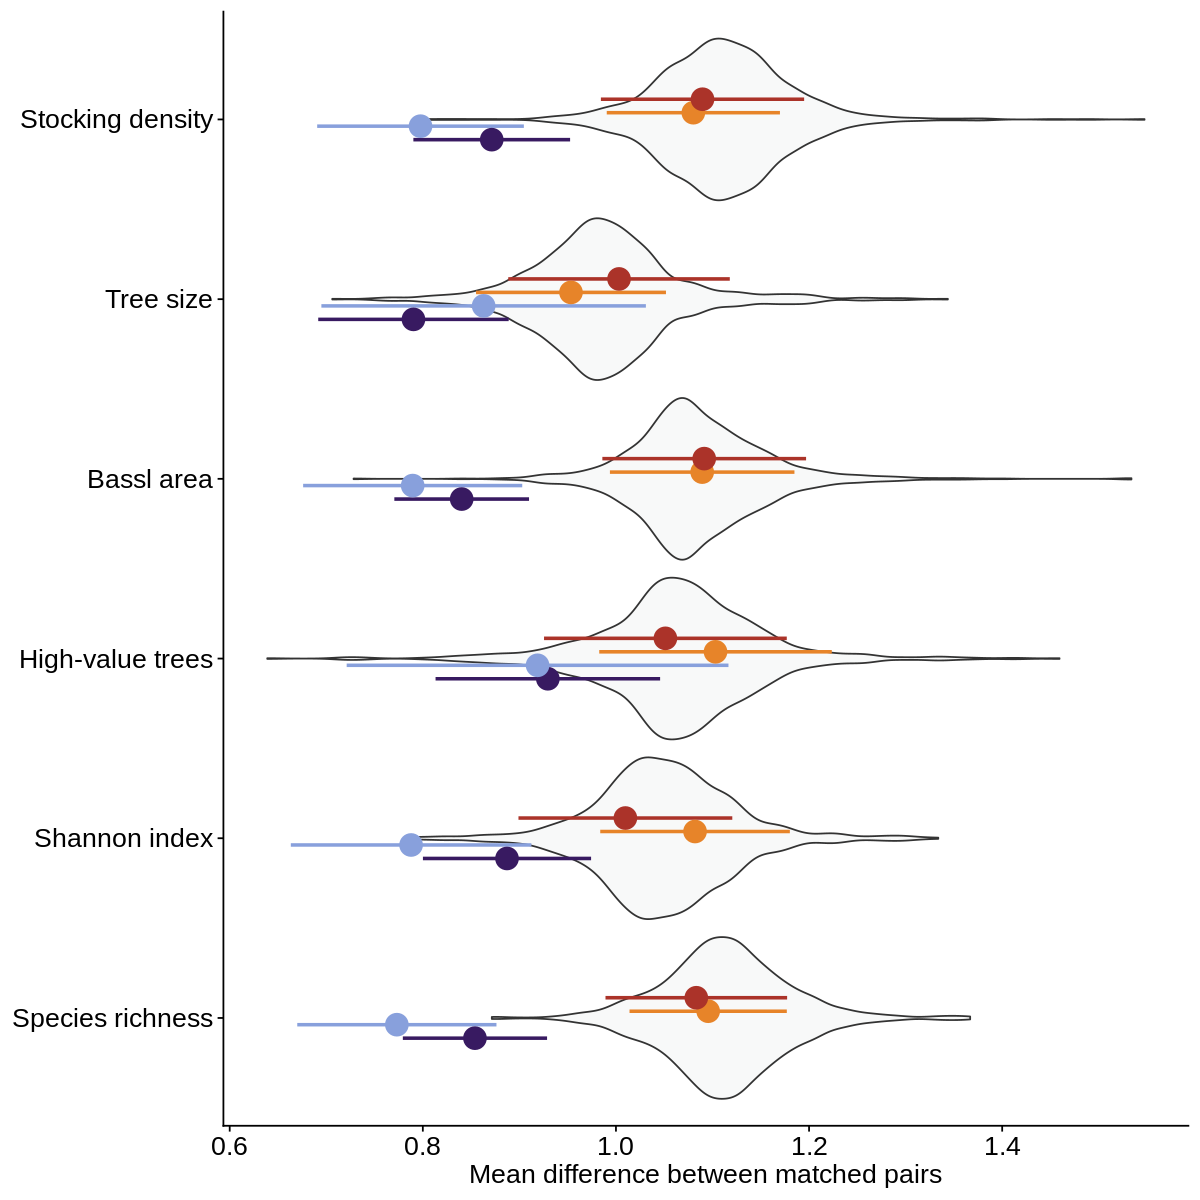

In [35]:
options(repr.plot.width=10, repr.plot.height=10)

(pair_dif_plot <- ggplot() + 
                     geom_violin(data = ran_dif, aes(value, metric2), fill = '#F8F9F9', scale = 'width') +

                    geom_pointrange(data = all_dif2, 
                                    aes(y = metric2, x = mean, xmin = mean -(1.96*se), xmax = mean + (se*1.96), colour = dataset),
                                       position = position_dodge(width =0.3), stroke = 2, size = 1) + 
                    labs(x='Mean difference between matched pairs') +
                    theme_cowplot() +
            scale_colour_manual(values = c(pal[2], pal[1], pal[6], pal[5], pal[4])) +
                    scale_y_discrete(labels = c('Species richness', 'Shannon index', 'High-value trees', 
                                        'Bassl area', 'Tree size', 'Stocking density')) +
                     theme(text = element_text(size = 16),  
                     axis.title.y=element_blank(), 
                     axis.text=element_text(size = 16),
                     #axis.text.y=element_blank(),
                     legend.position = 'top', legend.title = element_blank()) +
                     guides(color = 'none')
 )

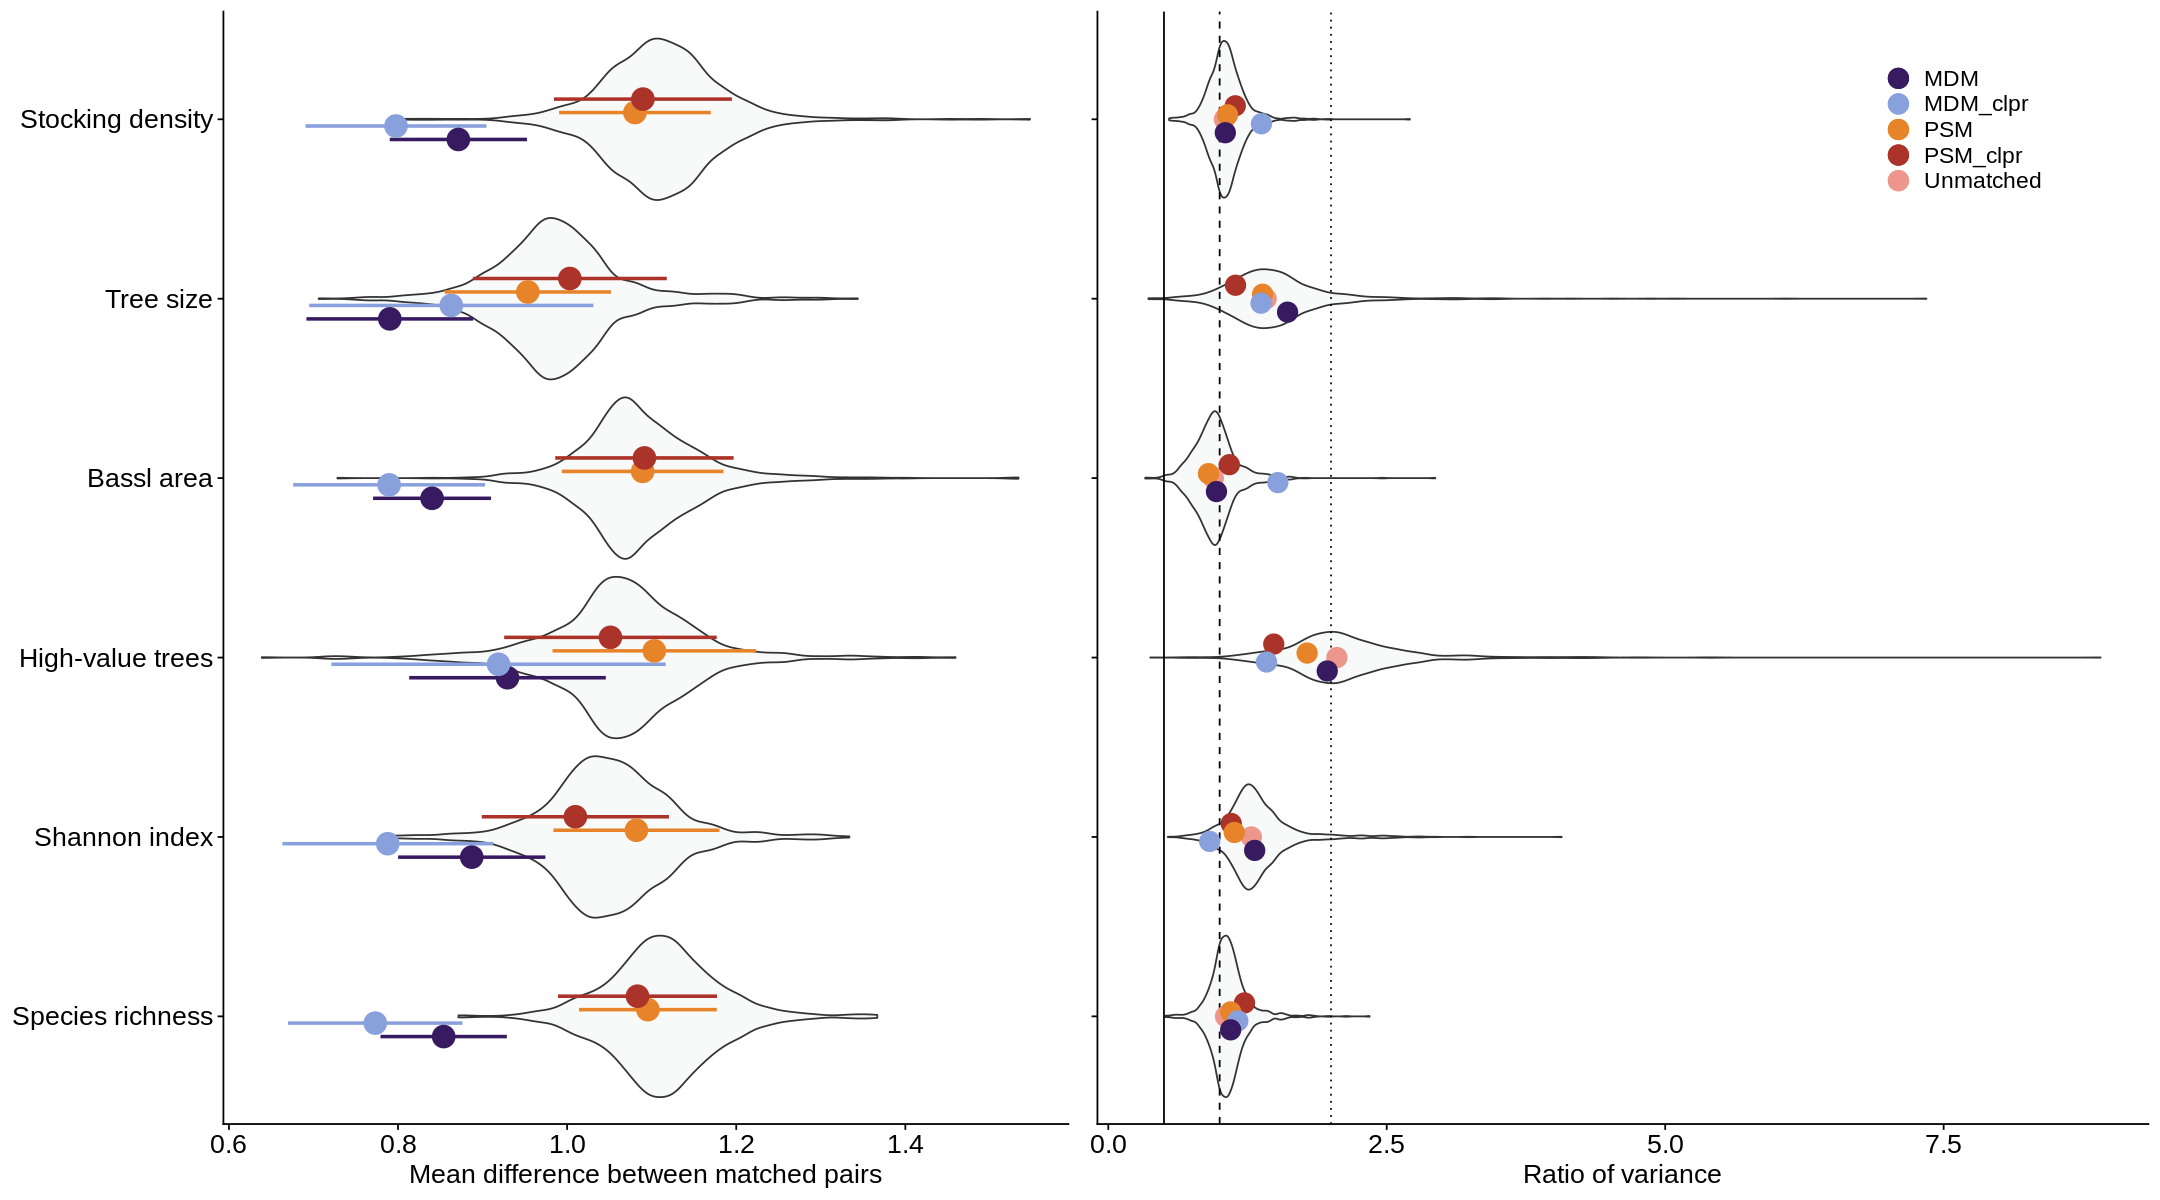

In [36]:
options(repr.plot.width=18, repr.plot.height=10)

dif_grid <-  plot_grid(pair_dif_plot, rvar_plot)
dif_grid

In [37]:
ggsave(dif_grid, 'png', filename = 'figures/dif_ratio_var_plt_unob.png', width = 20, height = 10)

# Randomly generated matches

In [38]:
###read in the ranly gernated matching set ups
##list of matches

n = 1000

num <- str_pad(1:n, pad = 0, width = 3, "left")
matches <- paste0('match_',num)

matched_data = list()

for(i in 1:n){
        tryCatch({

    matched_data[[i]] <- read.csv(paste0('data/randomised/match_',num[i],'.csv'))
            },error=function(e){})
    
        }
                 

Warning message in file(file, "rt"):
“cannot open file 'data/randomised/match_1000.csv': No such file or directory”


In [39]:
##read in th mathcing set ups for each match
match_info <- read.csv('data/randomised/match_info.csv')

In [40]:
summary(match_info$percent_trt_matched)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.3021 60.2719 83.6858 73.2554 97.5831 97.5831       5 

In [41]:
length(match_info$percent_trt_matched[match_info$percent_trt_matched > 10])

[1] 932

In [42]:
##what is the smd for unobervered covarites
metrics = unique(pm_long$var)

smd_df3 <- data.frame()

for(i in 1:n) {
    tryCatch({

    match = matches[i]
        data <-  matched_data[[i]] %>%
                    select(plot_cluster, treatment) %>%
                     left_join(pm, by = 'plot_cluster')  %>%
                        select(treatment, all_of(metrics))
         
        smd <- data %>%
                 group_by(treatment) %>%
                 summarize(across(all_of(metrics), ~mean(.x))) %>%
                 ungroup() %>%
                summarize(across(.cols = stocking_ha:hve_sp, ~ (last(.x) - first(.x)))) %>%
                pivot_longer(cols = everything(), names_to = 'metric', values_to = 'mean_dif') %>%
                left_join(trt_sd, by = 'metric') %>%
                mutate(smd = mean_dif / trt_sd, abs_smd = abs(mean_dif) / trt_sd, match = matches[i]) 
    
        smd_mean <- smd %>% 
                      group_by(match) %>%
                      summarize(metric = 'mean', across(mean_dif:abs_smd, mean)) %>%
                      select(metric:abs_smd, match)  
        
        smd_df3 = bind_rows(smd_df3, smd, smd_mean)
                    },error=function(e){})

     }

In [43]:
bal_df <- smd_df3 %>%
            left_join(match_info, by = 'match') %>%
            #filter(method =='MDM') %>%

            mutate(replacement = ifelse(replacement == 'FALSE', 'no', 'yes'), 
                    caliper = ifelse(caliper > 0, 'yes', 'no'),
                    metric2 = factor(metric, ordered = TRUE, levels = c('mean', 'richness', 'shannon', 'hve_sp', 'ba_ha', 'diam_mean', 'stocking_ha'))) %>%

                filter(percent_trt_matched > 10)

In [44]:
params = c('method', 'caliper', 'replacement', 'exact')
params2 = c('PSM', 'MDM', 'caliper', 'replacement', 'exact')


bal_par_long <- bal_df %>%
                    #filter(method =='MDM') %>%
                    select(match, metric, metric2, smd, abs_smd, all_of(params)) %>%
                    mutate(PSM = ifelse(method =='PSM', 'yes', 'no'), 
                           MDM = ifelse(method =='MDM', 'yes', 'no')) %>%

                    pivot_longer(cols = all_of(params2), names_to = 'parameter', values_to = 'value') %>%
                    filter(value == 'yes') %>%
                    group_by(metric2, parameter) %>%
                    summarize(mean_smd = mean(abs_smd), se = sd(abs_smd)/sqrt(n()), 
                              up_ci = mean_smd + (2 * se), lo_ci = mean_smd - (2 * se)) %>%

                     mutate(parameter = factor(parameter, ordered = TRUE, levels = c('caliper','exact','replacement','MDM','PSM'))) %>%
                     ungroup()


`summarise()` has grouped output by 'metric2'. You can override using the `.groups` argument.



In [45]:
bal_df_mean <- bal_df %>%  
                #filter(method =='MDM') %>% 
                group_by(metric2) %>% 
                mutate(abs_smd = mean(abs_smd)) 

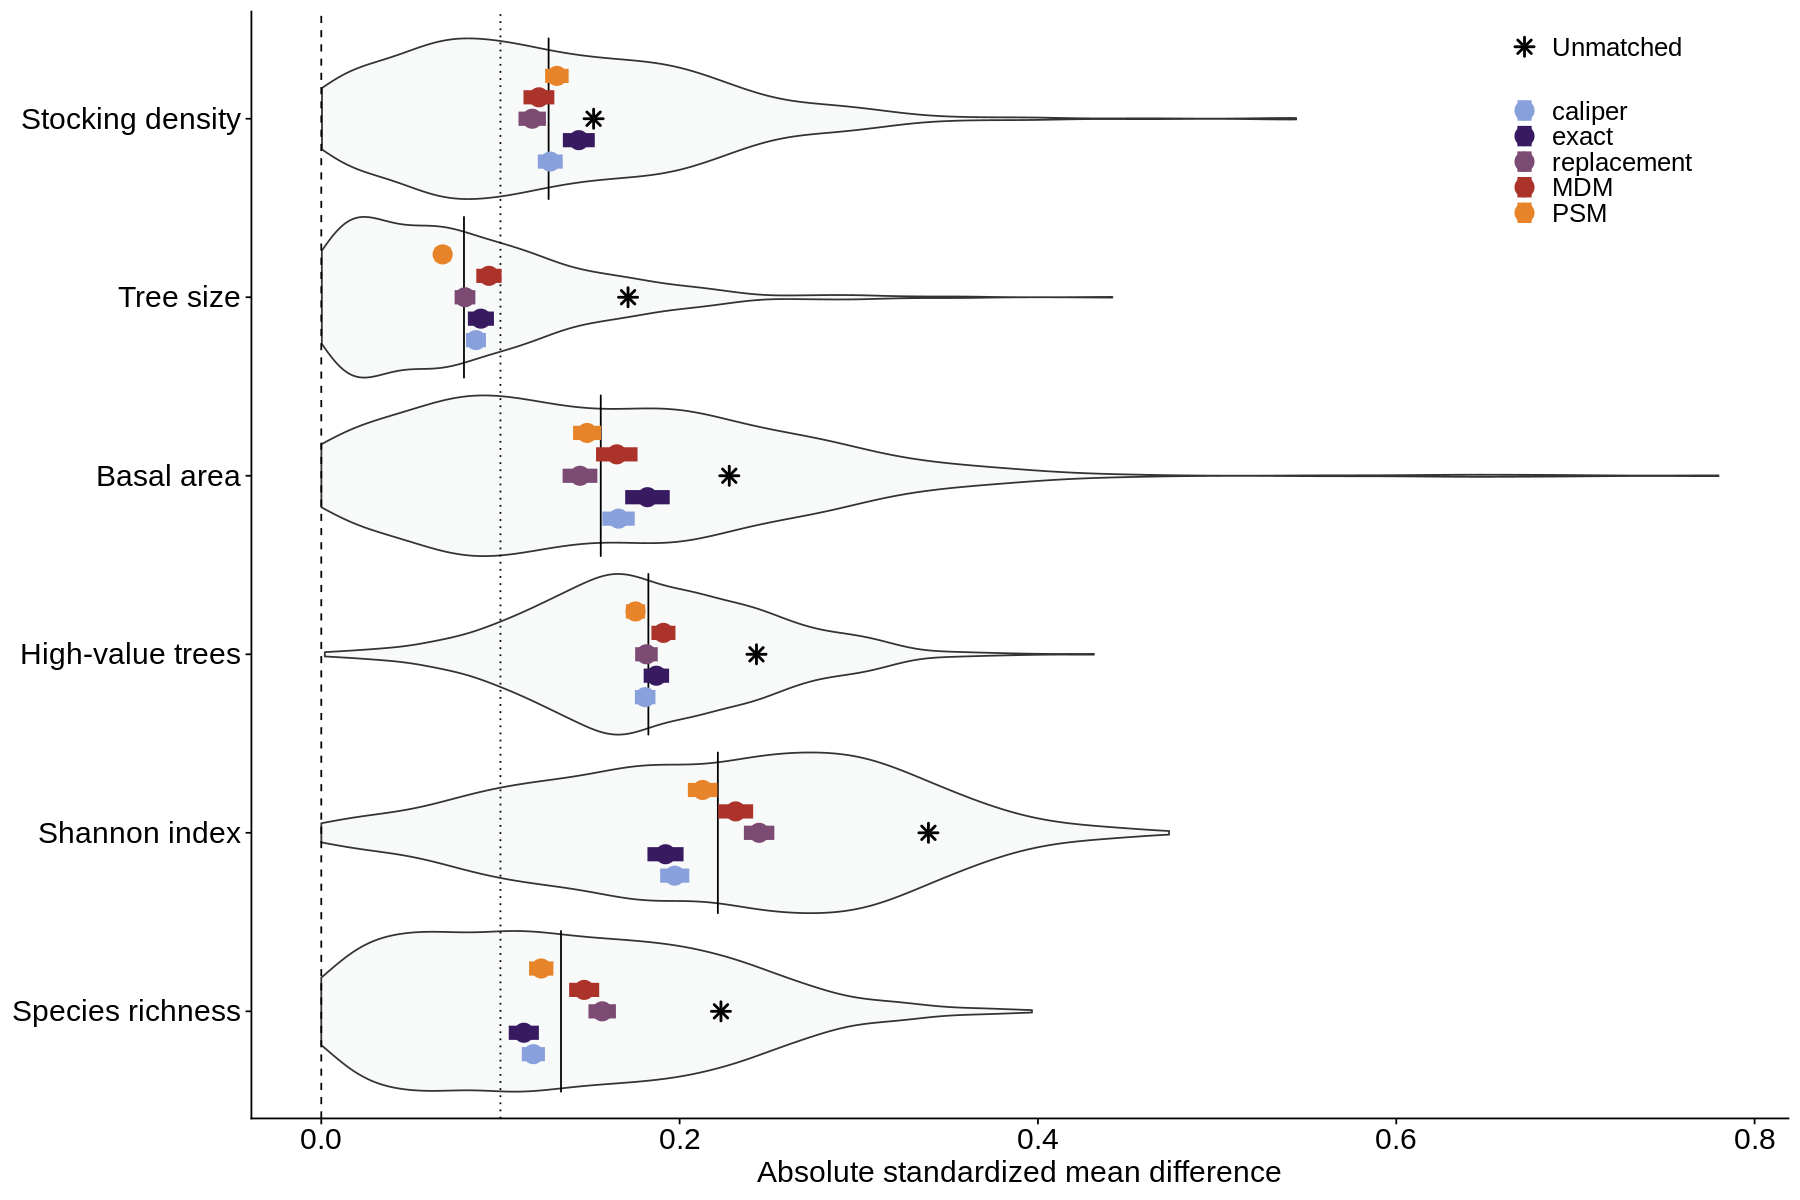

In [46]:
options(repr.plot.width=15, repr.plot.height=10)


(bal_par_plt <-   ggplot() +
                         geom_violin(data = filter(bal_df, metric2 != 'mean'), aes(abs_smd, metric2), fill = '#F8F9F9', scale = 'width') +    
                         geom_violin(data = filter(bal_df_mean, metric2 != 'mean'), aes(abs_smd, metric2), colour = 'black', scale = 'width') +
                         geom_point(data = filter(smd_df, dataset == 'Unmatched' & metric2 != 'mean'), aes(x = abs_smd, metric, shape = dataset),  colour = 'black', size = 3, stroke = 1.2) +
                         scale_shape_manual(values = c('Unmatched'=8)) +
                         
                         geom_vline(xintercept = 0,linetype = 'dashed') + 
                         geom_vline(xintercept = 0.1, linetype = 'dotted') +
                         geom_linerange(data = filter(bal_par_long, metric2 != 'mean'), aes(xmin = lo_ci, xmax= up_ci,
                                                                   y = metric2, colour = parameter), size = 4,
                                    position = position_dodge(width =0.6)) +
                         geom_point(data = filter(bal_par_long, metric2 != 'mean'), aes(x = mean_smd,
                                                                   y = metric2, colour = parameter), size = 5,
                                    position = position_dodge(width =0.6)) +
 
                         theme_cowplot() +
                         scale_colour_manual(values = c(pal[1],pal[2],pal[3],pal[5], pal[6])) +
                         scale_y_discrete(labels = c('Species richness', 'Shannon index', 'High-value trees', 
                                        'Basal area', 'Tree size', 'Stocking density')) +
                         labs(x='Absolute standardized mean difference') +
                         theme(text = element_text(size = 18),  
                                 axis.title.y =element_blank(), 
                                 axis.text=element_text(size = 18),
                                 legend.position = c(0.82, 0.9), legend.title = element_blank())

 )

In [47]:
ggsave(bal_par_plt, 'png', filename = 'figures/ran_match_bal_plt.png', width = 12, height = 12)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



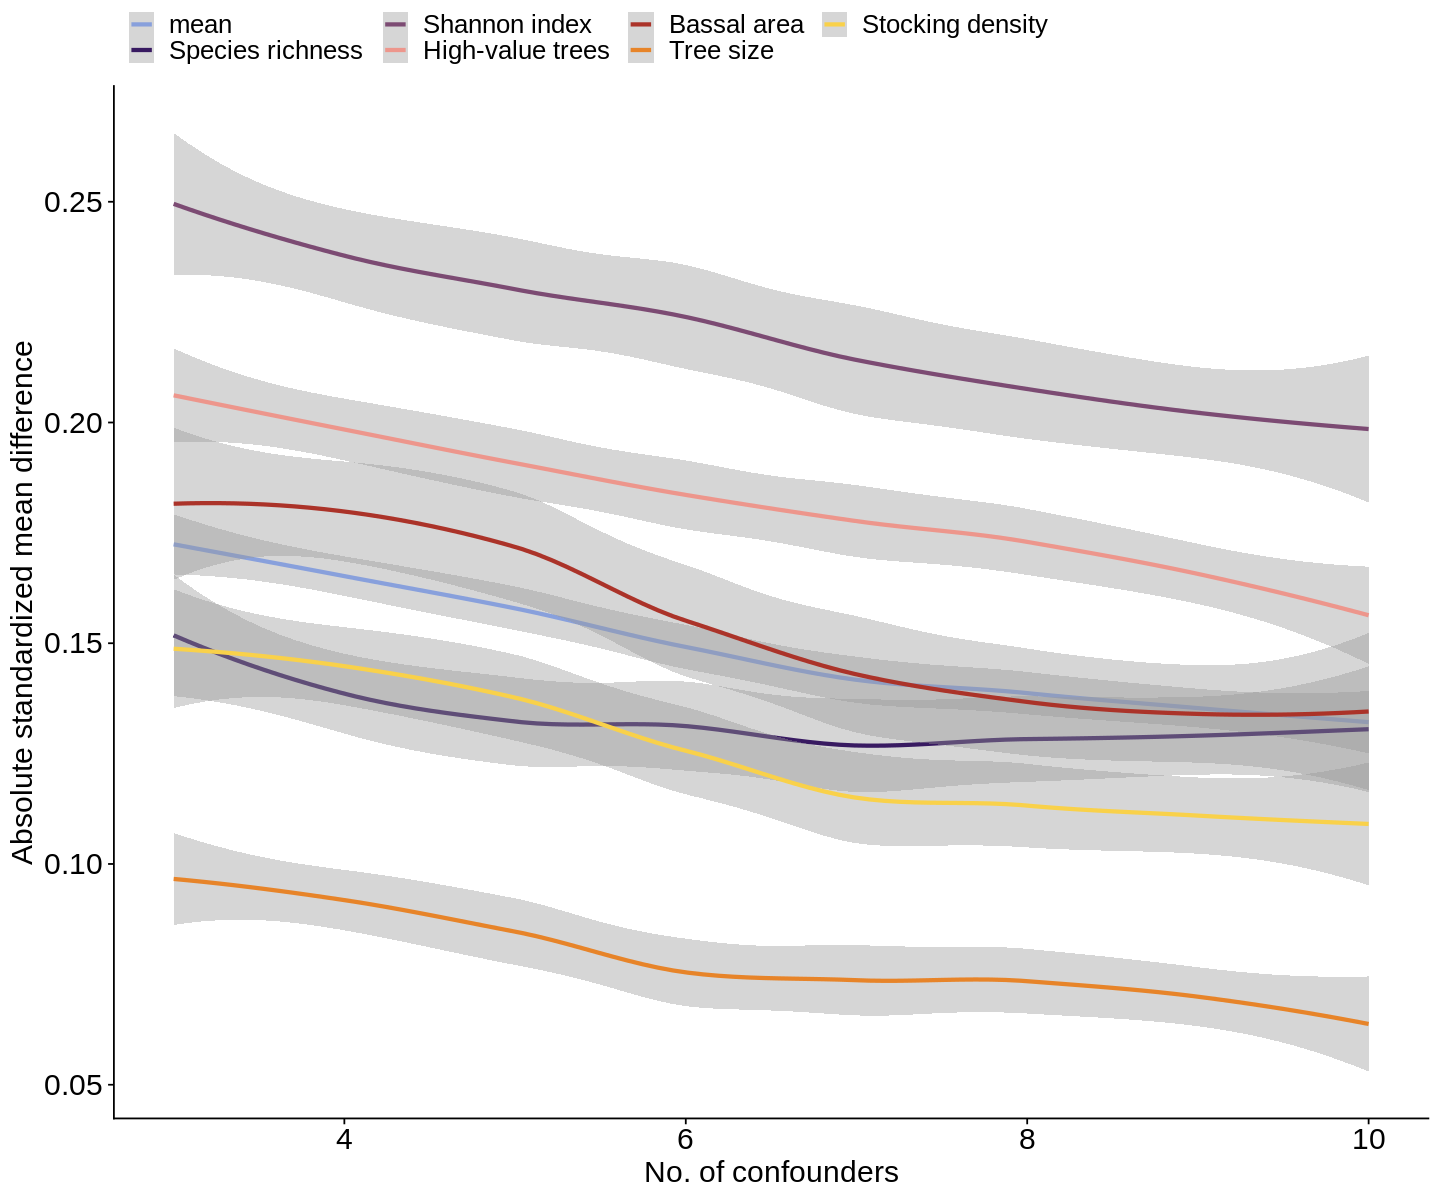

In [48]:
options(repr.plot.width=12, repr.plot.height=10)

(bal_plt1 <-  bal_df %>%
             ggplot() +
             geom_smooth(aes(no.conf, abs_smd,  colour  = metric2), size = 1.2) +
             theme_cowplot() +
             scale_colour_manual(values = c(pal[1], pal[2:7]), labels = c('mean', 'Species richness', 'Shannon index', 'High-value trees', 
                                        'Bassal area', 'Tree size', 'Stocking density')) +
             labs(x = 'No. of confounders', y = 'Absolute standardized mean difference') +
                theme(text = element_text(size = 18),  
                                 axis.text=element_text(size = 18),
                                 legend.position = 'top', legend.title = element_blank())
)

In [49]:
#ggsave(bal_plt1, 'png', filename = 'figures/ran_match_no_conf_plt.png', width = 12, height = 10)

## correlation of smd for observred and unobservred

In [50]:
smd_obs <- read.csv('data/randomised/random_match_smds.csv')

In [51]:
unob_conf <- metrics
ob_conf <- c('slope', 'elevation', 'nearest_road', 'travel_time_city', 'precipitation', 'dist_settle', 'treecover', 'human_pop', 'nearest_river',
             'temperature', 'province', 'veg_type', 'agri_suit', 'dist_lusaka', 'ecoregion')

In [52]:
ob_conf_cat <- c('prov_num_1','prov_num_2','prov_num_3','prov_num_4', 'prov_num_5', 'prov_num_6', 'prov_num_7', 'prov_num_8', 'prov_num_9', 'prov_num_10', 
                 'ecoregion_num_2', 'ecoregion_num_7', 'ecoregion_num_9', 
                 'veg_num_1', 'veg_num_2', 'veg_num_3', 'veg_num_4')

ob_conf_cat2 <- c('province', 'ecoregion', 'veg_type')

ob_conf_con <- c('slope', 'elevation', 'nearest_road', 'travel_time_city', 'precipitation', 'dist_settle', 'treecover', 'human_pop', 'nearest_river', 'temperature','agri_suit','dist_lusaka')

In [53]:
smd_unob <- bal_df %>%
                rename('confounder' = 'metric') %>%
                select(match, confounder, abs_smd) %>%
                 mutate(type = 'unobservred')

In [54]:
smd_comp <- smd_obs %>% 
                select(match, confounder, smd) %>%
                  filter(confounder != 'distance' & match %in% bal_df$match) %>%
                    mutate(type = 'observred', abs_smd = abs(smd)) %>%
                    bind_rows(smd_unob) %>%
                        pivot_wider(id_cols = match, names_from = confounder, values_from = abs_smd) %>%
                        rename('human_pop' ='human_pop_2014', 'travel_time_city' = 'travel_time_city_2015', 'treecover' = 'treecover_2014') %>%
                rowwise() %>%
                mutate(province = mean(c_across(starts_with('prov_num')), na.rm = TRUE),
                           ecoregion = mean(c_across(starts_with('ecoregion_num')), na.rm = TRUE),
                           veg_type = mean(c_across(starts_with('veg_num')), na.rm = TRUE), 
                           mean_unob = mean(c_across(all_of(unob_conf)), na.rm = TRUE), 
                           mean_ob = mean(c_across(all_of(ob_conf)), na.rm = TRUE), 
                           mean_ob_con = mean(c_across(all_of(ob_conf_con)), na.rm = TRUE),
                           no.obs_covar = sum(!is.na(c_across(all_of(ob_conf)))),
                           per_0.1_obs = sum(c_across(all_of(ob_conf)) < 0.1, na.rm = TRUE)/no.obs_covar) %>%

                ungroup() %>%
                select(match, all_of(unob_conf),mean_unob, all_of(ob_conf), per_0.1_obs, mean_ob, no.obs_covar)

In [55]:
cor_mat <- round(cor(select(smd_comp, !match), method = 'spearman', use = "pairwise.complete.obs"),2)
cor_mat[lower.tri(cor_mat)] <- NA
order <- colnames(cor_mat)

In [56]:
##chosoe pallette
pal2 <- (met.brewer('OKeeffe1', n = 12, type = "continuous"))
###set brek points for pallette
breaks = c(-0.5, -0.3, -0.2, -0.099, 0, 0.099, 0.3, 0.5, 0.7, 0.8, 1)
values = c(pal2[1], pal2[2], pal2[3], 'white', 'white', pal2[7:12])

In [57]:
cor_df <- cor_mat %>% 
                as.data.frame() %>% 
                rownames_to_column('var1') %>%
                pivot_longer(cols = !var1, names_to = 'var2', values_to = 'value') %>%
                drop_na() %>%
                mutate(var1 = factor(var1, ordered = TRUE, levels = (order)), var2 = factor(var2, ordered = TRUE, levels = (order))) %>%
                filter(var1 %in% c(unob_conf, 'mean_unob')) %>%
                mutate(var1 = factor(var1, ordered = TRUE, levels = (order)), var2 = factor(var2, ordered = TRUE, levels = (order)),
                       value_g = cut(value, breaks =breaks, include.lowest = TRUE, ordered_result = TRUE))

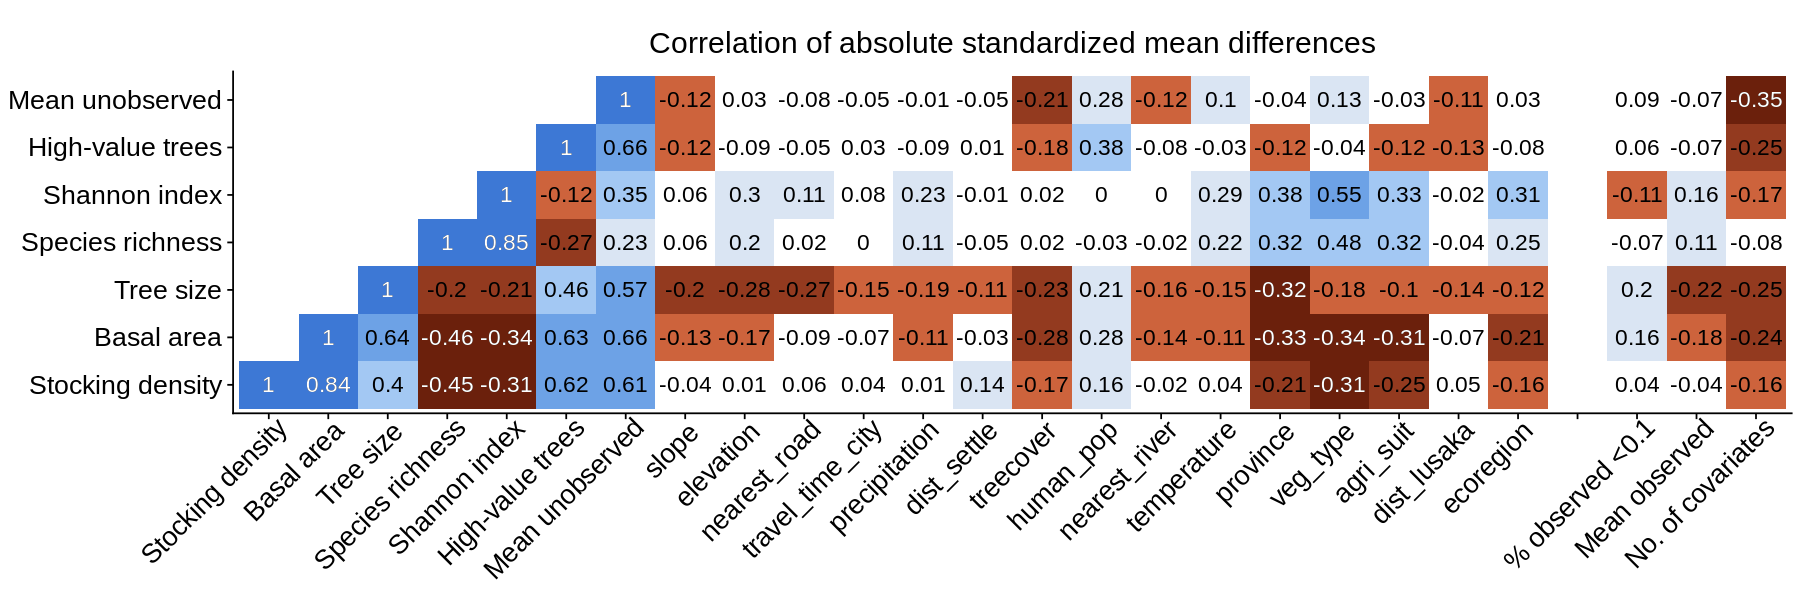

In [58]:
options(repr.plot.width=15, repr.plot.height=5)

(conf_corplt <-  ggplot() + 
                  geom_tile(data = cor_df, aes(x = var2, y = var1, fill=(value_g))) +
                 
                  geom_text(data = filter(cor_df, value < 0.8 | value > -0.3) , aes(var2, var1, label = value), color = "black", size = 4.8) +
                  geom_text(data = filter(cor_df, value > 0.8 | value < -0.3), aes(var2, var1, label = value), color = "white", size = 4.8) +
                  theme_cowplot() +
                  scale_fill_manual(values = values) +
 
                  scale_y_discrete(labels = c('Stocking density', 'Basal area',  'Tree size',  
                                              'Species richness',  'Shannon index', 'High-value trees', 'Mean unobserved')) +
 
                  scale_x_discrete(labels = (c('Stocking density', 'Basal area',  'Tree size',  
                                               'Species richness',  'Shannon index', 'High-value trees', 'Mean unobserved', order[8:22], 
                                                ' ', '% observed <0.1', 'Mean observed', 'No. of covariates')),
                                   limits = c(order[1:22], ' ', order[23:25]), drop=FALSE ) +
                
                  labs(title = 'Correlation of absolute standardized mean differences') +

                  theme(axis.title = element_blank(), legend.position= 'none',
                         legend.direction = "horizontal", 
                         plot.title = element_text(size = 18, face = 'plain', hjust = 0.5),
                         axis.text = element_text(size=16), 
                         axis.text.x = element_text(angle=45, hjust = 0.95), 
                         plot.margin = margin(t = 20,
                                              r = 5, 
                                              b = 5,  
                                              l = 5))
 )

In [59]:
ggsave(conf_corplt, 'png', filename = 'figures/ran_match_conf_cor_small_plt.png', width = 15, height = 5)

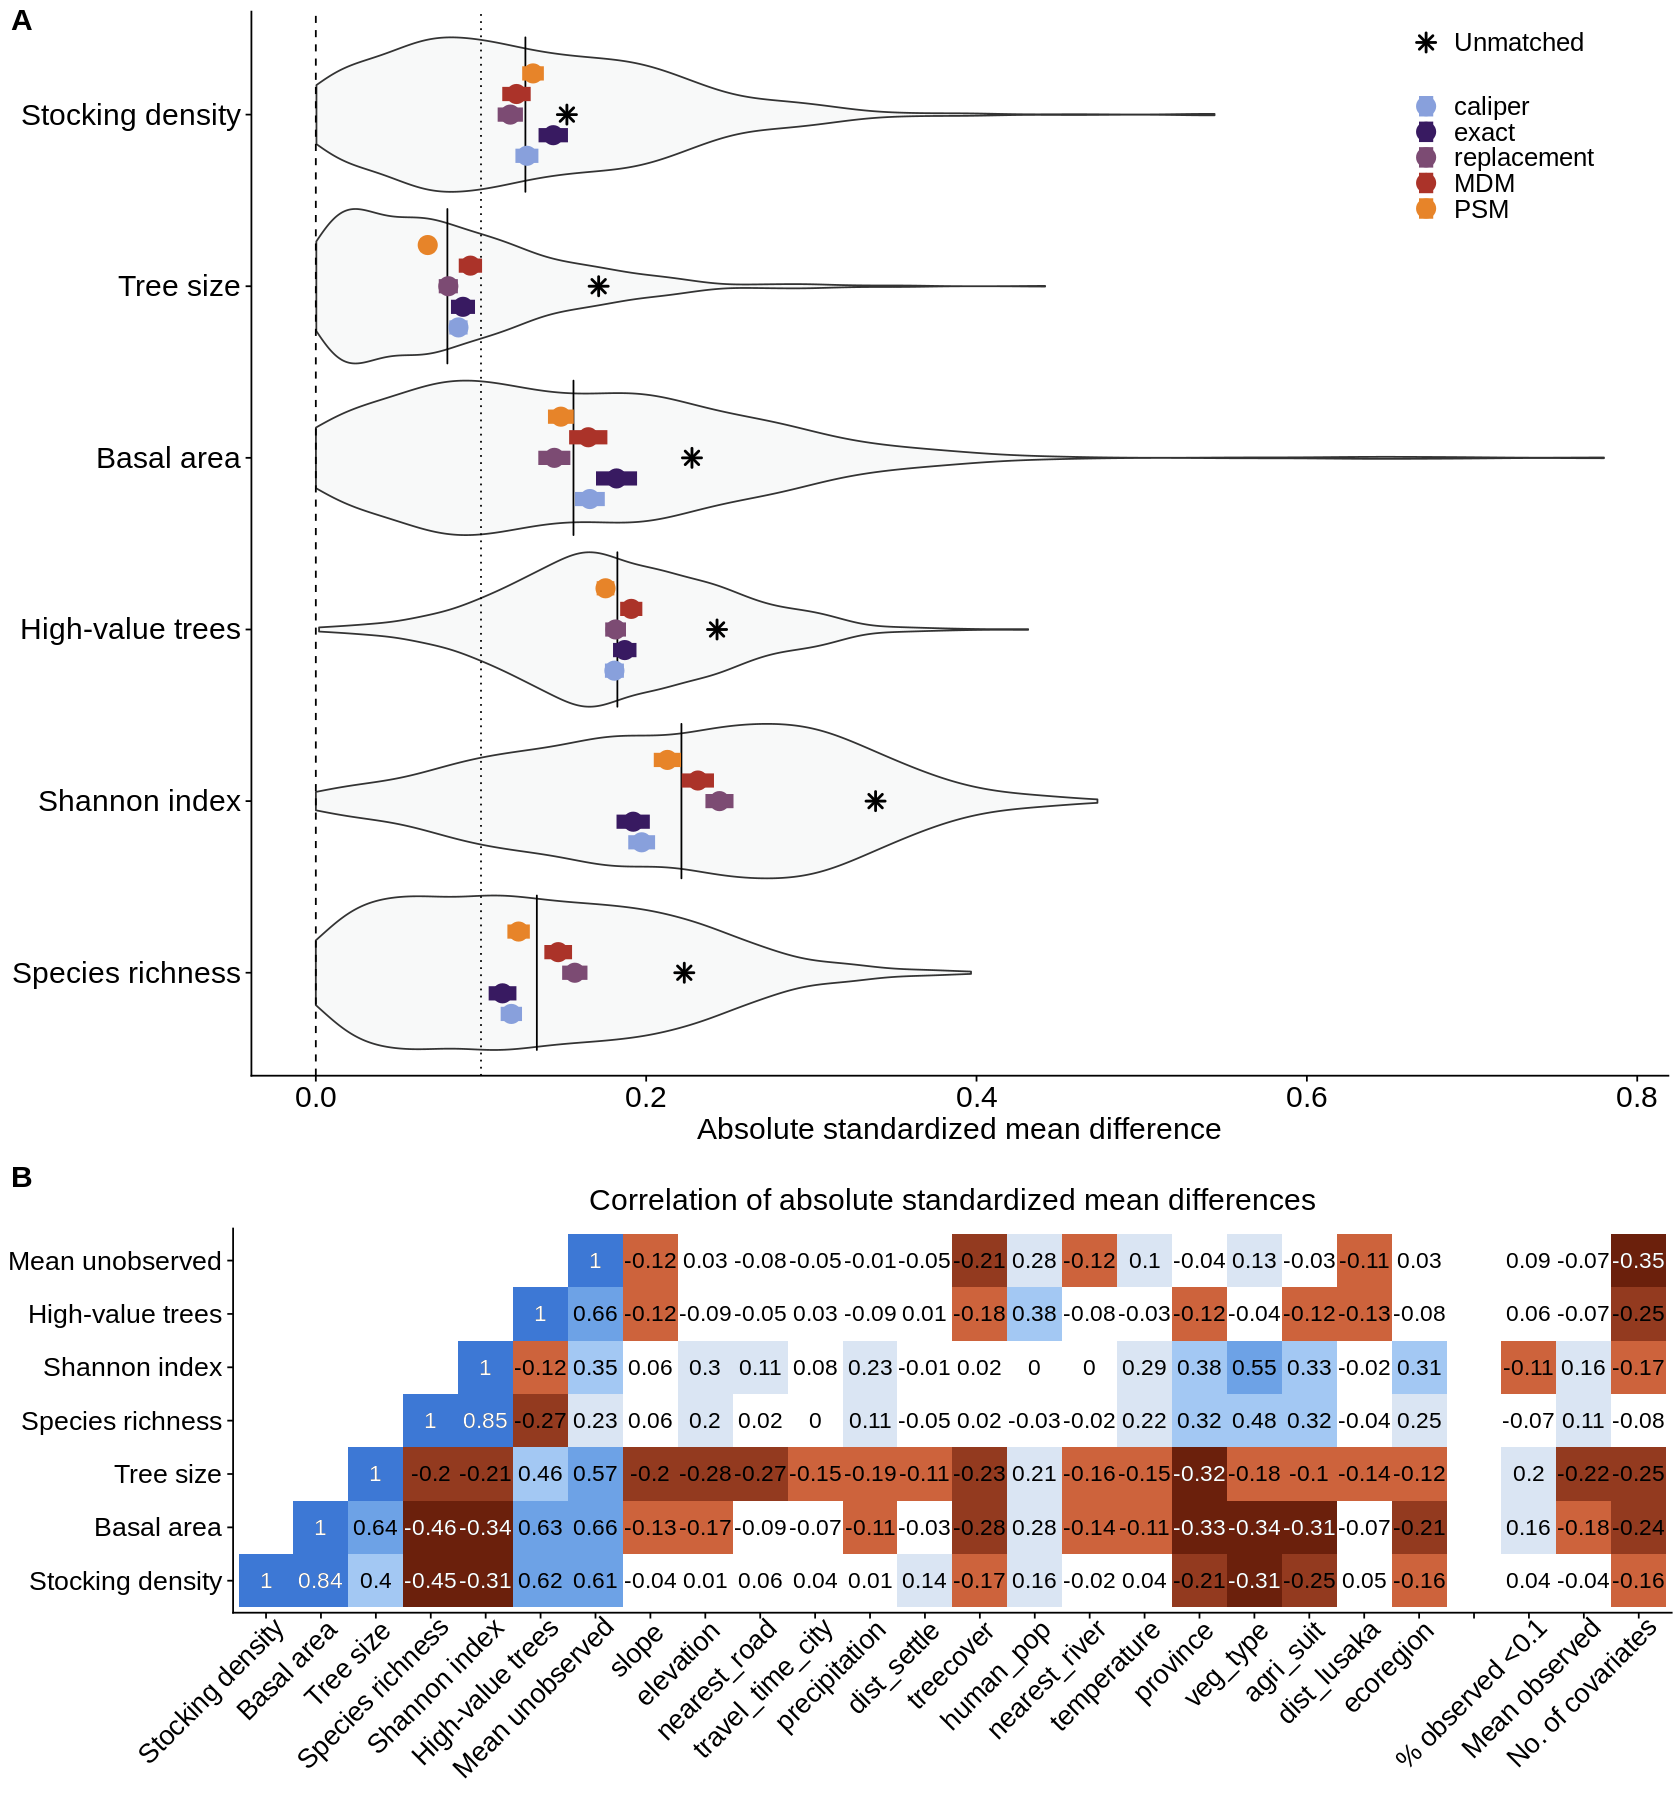

In [60]:
options(repr.plot.width=14, repr.plot.height=15)

#top_row <- plot_grid(bal_par_plt, bal_plt1, labels = c('A', 'B'), label_size = 18, rel_widths = c(1.6, 1))

(ran_match_grid <- plot_grid(bal_par_plt, conf_corplt, labels = c('A', 'B'), label_size = 18, ncol = 1,   rel_heights = c(1.8,1)))

In [61]:
ggsave(ran_match_grid, 'png', filename = 'figures/ran_match_grid_plt.png', width = 13.5, height = 14)

In [62]:
##Why is Human pop best correlated? 
h_pop <- smd_obs %>% left_join(match_info) %>% mutate(smd = abs(smd)) %>% filter(confounder == 'human_pop_2014')

Joining, by = c("match", "method")



In [63]:
cor(h_pop$smd, h_pop$percent_trt_matched)

[1] 0.1601325

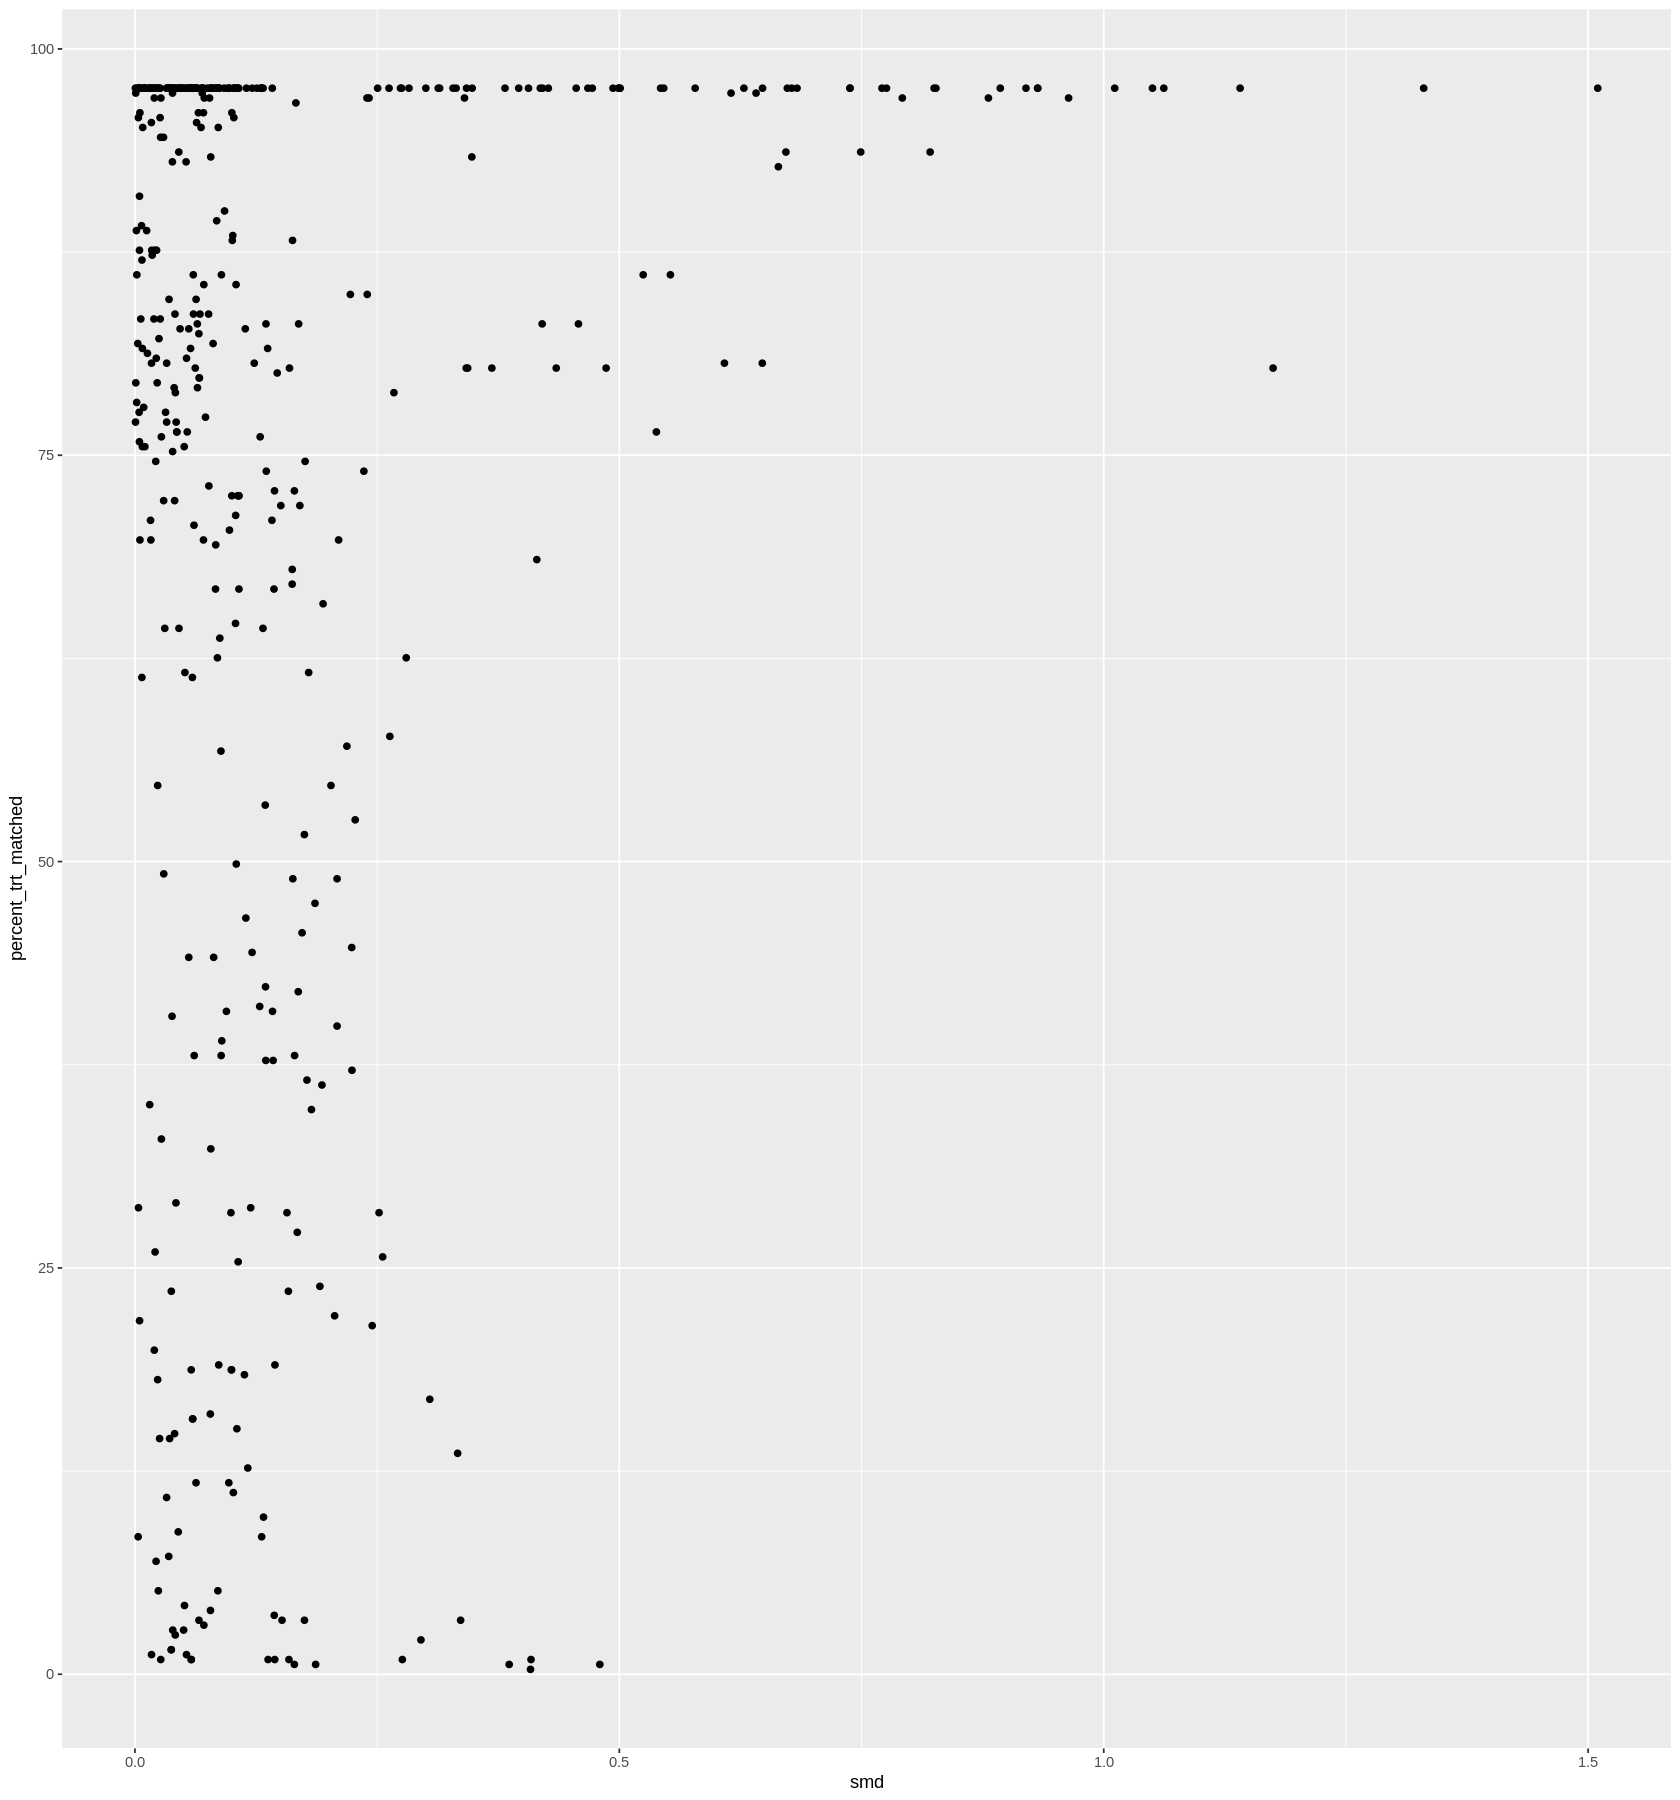

In [64]:
ggplot() + 
geom_point(data = h_pop, aes(smd, percent_trt_matched))

# Cor mat for raw data

In [65]:
cor_data <- unm %>%
                left_join(pm, by = 'plot_cluster') %>%
                rename('human_pop' ='human_pop_2014', 'travel_time_city' = 'travel_time_city_2015', 'treecover' = 'treecover_2014') %>%
                select(all_of(unob_conf), all_of(ob_conf_con))

In [66]:
cor_mat <- round(cor(cor_data, use = "pairwise.complete.obs"),2)
cor_mat[lower.tri(cor_mat)] <- NA
order <- colnames(cor_mat)

In [67]:
cor_df2 <- cor_mat %>% 
                as.data.frame() %>% 
                rownames_to_column('var1') %>%
                pivot_longer(cols = !var1, names_to = 'var2', values_to = 'value') %>%
                drop_na() %>%
                mutate(var1 = factor(var1, ordered = TRUE, levels = (order)), var2 = factor(var2, ordered = TRUE, levels = (order)),
                       value_g = cut(value, breaks =breaks, include.lowest = TRUE, ordered_result = TRUE)) %>%
                filter(var1 %in% unob_conf)

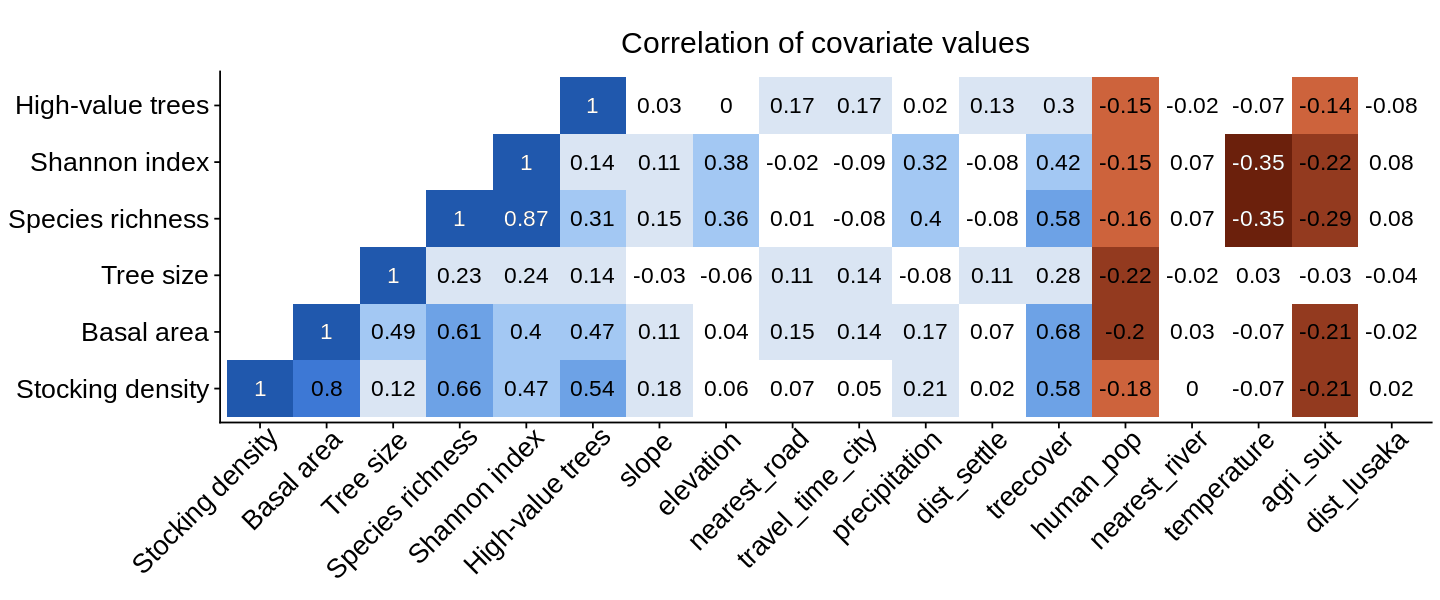

In [68]:
options(repr.plot.width=12, repr.plot.height=5)

(conf_data_corplt <-  ggplot() + 
                  geom_tile(data = cor_df2, aes(x = var2, y = var1, fill=value_g)) +
                  geom_text(data = filter(cor_df2, value < 0.8 | value > -0.3) , aes(var2, var1, label = value), color = "black", size = 4.8) +
                  geom_text(data = filter(cor_df2, value > 0.8 | value < -0.3), aes(var2, var1, label = value), color = "white", size = 4.8) +
                  theme_cowplot() +
                scale_fill_manual(values = values) +
 
                 scale_y_discrete(labels = c('Stocking density', 'Basal area',  'Tree size',  
                                              'Species richness',  'Shannon index', 'High-value trees')) +
                 scale_x_discrete(labels = c('Stocking density', 'Basal area',  'Tree size',  
                                               'Species richness',  'Shannon index', 'High-value trees', order[7:18])) +
                
                  labs(title = 'Correlation of covariate values') +

                  theme(axis.title = element_blank(), legend.position= 'none',
                         legend.direction = "horizontal", 
                         plot.title = element_text(size = 18, face = 'plain', hjust = 0.5),
                         axis.text = element_text(size=16), 
                         axis.text.x = element_text(angle=45, hjust = 0.95), 
                         plot.margin = margin(t = 20,
                                              r = 5, 
                                              b = 5,  
                                              l = 5))
 )

In [69]:
ggsave(conf_data_corplt, 'png', filename = 'figures/data_conf_cor_plt.png', width = 12, height = 5)

In [70]:
cor_df <- cor_df %>% 
                transmute(var1 = as.character(var1), var2 = as.character(var2), smd_cor = value)

cor_df2 <- cor_df2 %>% 
                transmute(var1 = as.character(var1), var2 = as.character(var2), data_cor = value)

cor_comp <- left_join(cor_df, cor_df2, by = c('var1', 'var2'))

`geom_smooth()` using formula 'y ~ x'



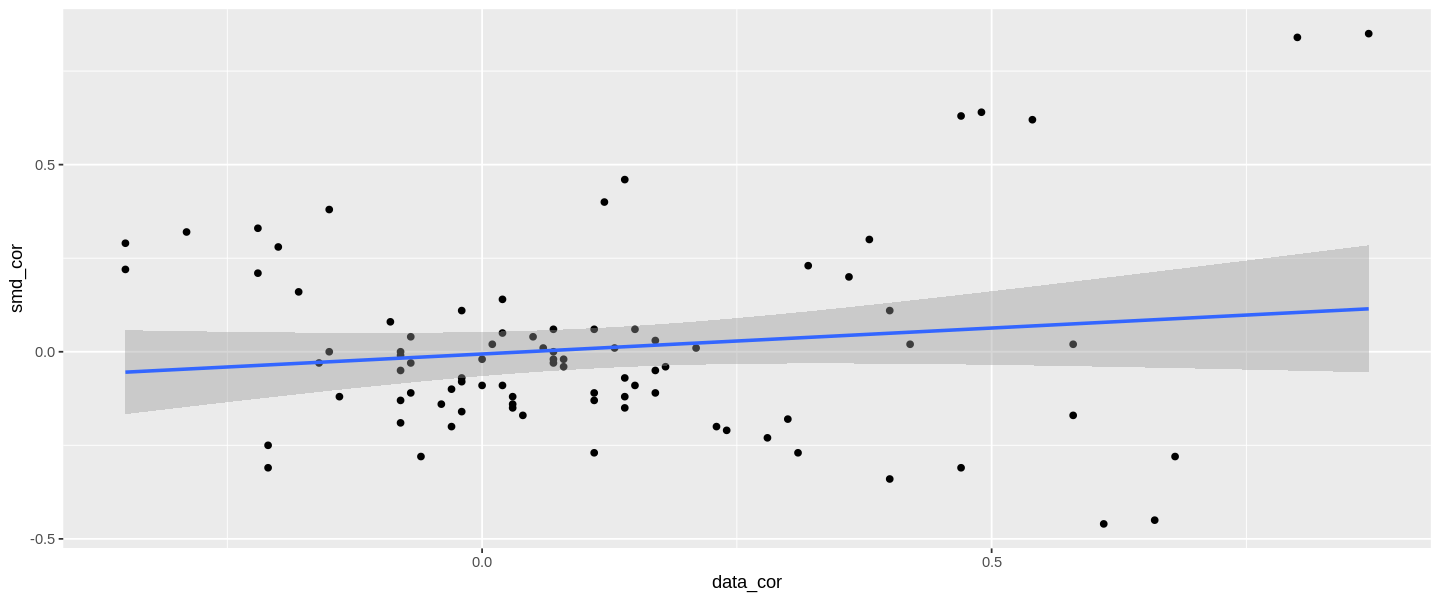

In [71]:
ggplot() +
geom_point(data = filter(cor_comp, data_cor != 1), aes(data_cor, smd_cor)) +
geom_smooth(data = filter(cor_comp, data_cor != 1), aes(data_cor, smd_cor), method = 'lm')

# full cor mat

In [72]:
smd_comp <- smd_obs %>% 
                select(match, confounder, smd) %>%
                  filter(confounder != 'distance' & match %in% bal_df$match) %>%
                    mutate(type = 'observred', abs_smd = abs(smd)) %>%
                    bind_rows(smd_unob) %>%
                        pivot_wider(id_cols = match, names_from = confounder, values_from = abs_smd) %>%
                        rename('human_pop' ='human_pop_2014', 'travel_time_city' = 'travel_time_city_2015', 'treecover' = 'treecover_2014') %>%
                ungroup() %>%
                select(match, all_of(unob_conf), all_of(ob_conf_con), all_of(ob_conf_cat))

In [73]:
cor_mat <- round(cor(select(smd_comp, !match), use = "pairwise.complete.obs"),2)
cor_mat[lower.tri(cor_mat)] <- NA
order <- colnames(cor_mat)

In [74]:
cor_df2 <- cor_mat %>% 
                as.data.frame() %>% 
                rownames_to_column('var1') %>%
                pivot_longer(cols = !var1, names_to = 'var2', values_to = 'value') %>%
                drop_na() %>%
                mutate(var1 = factor(var1, ordered = TRUE, levels = (order)), var2 = factor(var2, ordered = TRUE, levels = (order)), 
                                    value_g = cut(value, breaks =breaks, include.lowest = TRUE, ordered_result = TRUE))

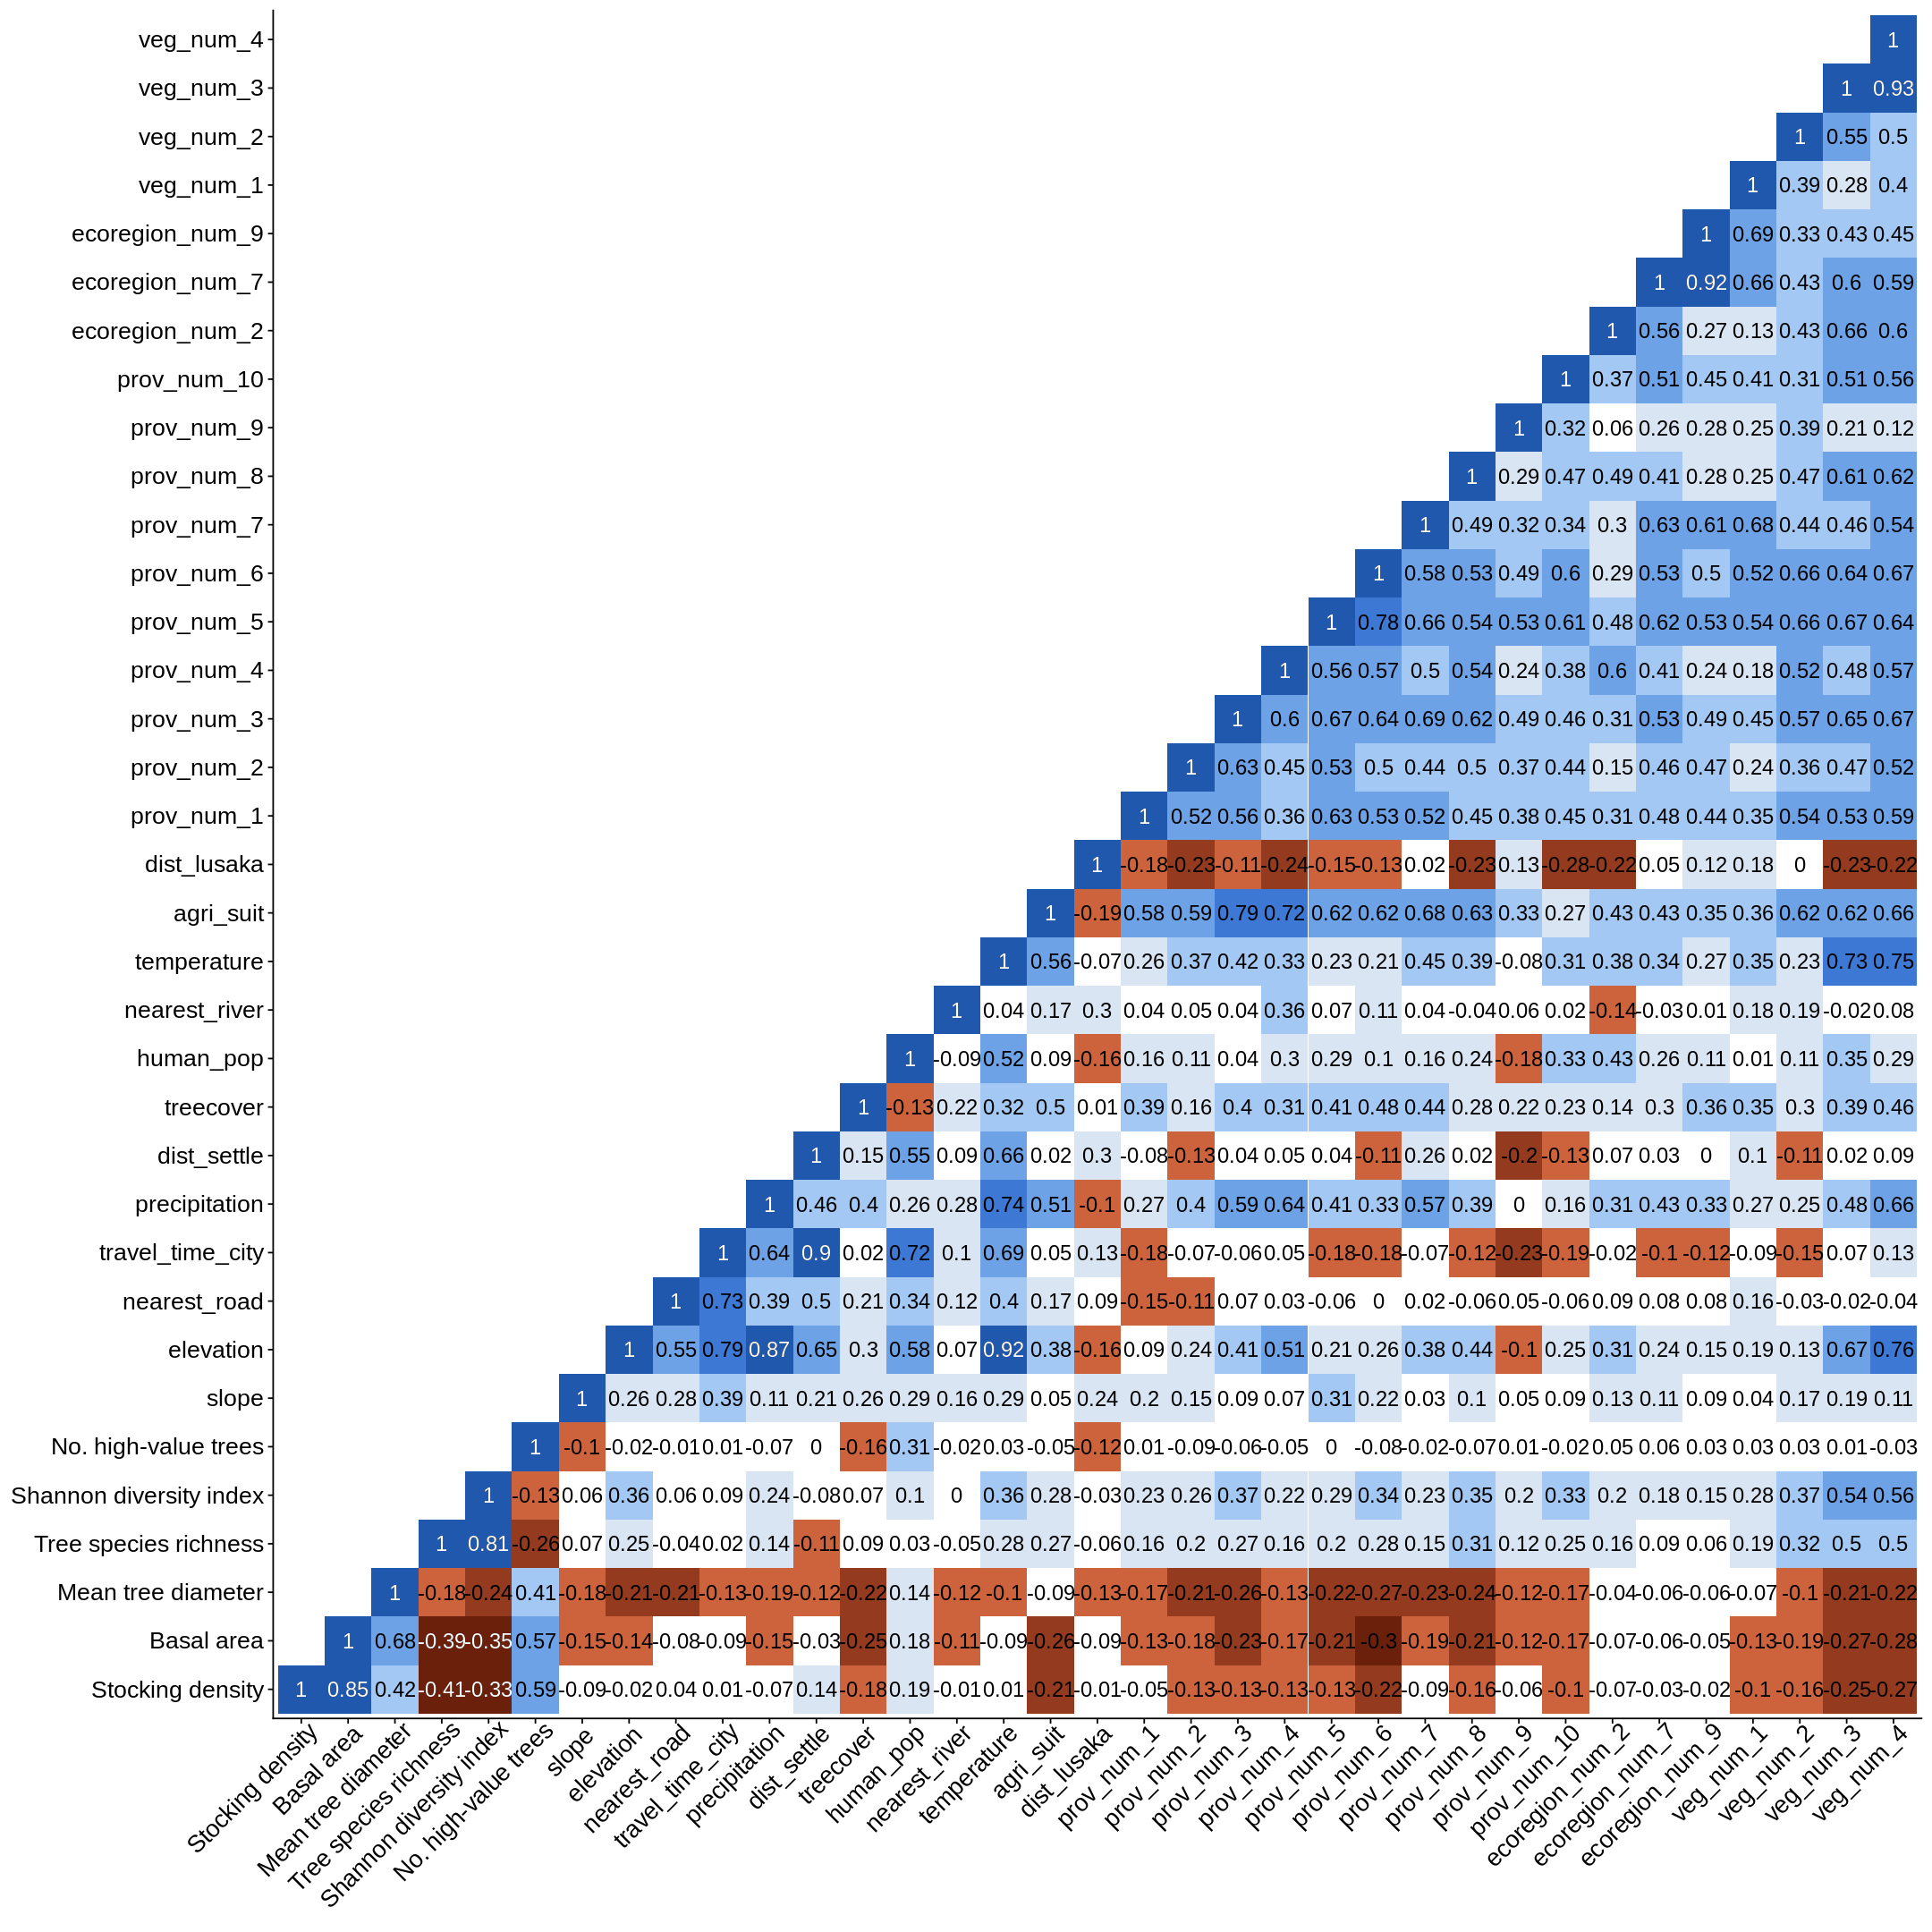

In [75]:
options(repr.plot.width=18, repr.plot.height=18)

(conf_corplt2 <-  ggplot() + 
                  geom_tile(data = cor_df2, aes(x = var2, y = var1, fill=value_g)) +
                  geom_text(data = filter(cor_df2, value < 0.8 | value > -0.3) , aes(var2, var1, label = value), color = "black", size = 5) +
                  geom_text(data = filter(cor_df2, value > 0.8 | value < -0.3), aes(var2, var1, label = value), color = "white", size = 5) +
                  theme_cowplot() +
                scale_fill_manual(values = values) +
 
                  scale_y_discrete(labels = c('Stocking density', 'Basal area',  'Mean tree diameter',  
                                         'Tree species richness',  'Shannon diversity index', 'No. high-value trees',order[7:35])) +
                  scale_x_discrete(labels = c('Stocking density', 'Basal area',  'Mean tree diameter',  
                                         'Tree species richness',  'Shannon diversity index', 'No. high-value trees', order[7:35])) +

                  theme(axis.title = element_blank(), legend.position= 'none',
                         legend.direction = "horizontal", axis.text = element_text(size=16), 
                         axis.text.x = element_text(angle=45, hjust = 0.95))
 )

In [76]:
ggsave(conf_corplt2, 'png', filename = 'figures/ran_match_conf_cor_full_plt.png', width = 18, height = 18)

In [77]:
bal_obs_df <-  smd_obs %>% 
                mutate(abs_smd = abs(smd)) %>%
                select(match, confounder, abs_smd) %>%
                filter(confounder != 'distance') %>%
                pivot_wider(id_cols = match, names_from = confounder, values_from = abs_smd) %>%
                rename('human_pop' ='human_pop_2014', 'travel_time_city' = 'travel_time_city_2015', 'treecover' = 'treecover_2014') %>%
                    
                rowwise() %>%
                mutate(province = mean(c_across(starts_with('prov_num')), na.rm = TRUE),
                        ecoregion = mean(c_across(starts_with('ecoregion_num')), na.rm = TRUE),
                        veg_type = mean(c_across(starts_with('veg_num')), na.rm = TRUE)) %>%
                ungroup() %>%

                pivot_longer(cols = !match, names_to = 'confounder', values_to = 'abs_smd') %>%
                drop_na() %>%
                    
                 left_join(match_info, by = 'match') %>%
                 mutate(replacement = ifelse(replacement == 'FALSE', 'no', 'yes'), 
                    caliper = ifelse(caliper > 0, 'yes', 'no'),
                    PSM = ifelse(method =='PSM', 'yes', 'no'), 
                    MDM = ifelse(method =='MDM', 'yes', 'no')) %>%
              filter(percent_trt_matched > 10) 

In [78]:
params = c('PSM', 'MDM', 'caliper', 'replacement', 'exact')


bal_obs_par_long <- bal_obs_df %>%
                    select(match, confounder, abs_smd, all_of(params)) %>%
                    pivot_longer(cols = all_of(params), names_to = 'parameter', values_to = 'value') %>%
                    filter(value == 'yes') %>%
                    group_by(confounder, parameter) %>%
                    summarize(mean_smd = mean(abs_smd), se = sd(abs_smd)/sqrt(n()), 
                              up_ci = mean_smd + (2 * se), lo_ci = mean_smd - (2 * se)) %>%

                     mutate(parameter = factor(parameter, ordered = TRUE, levels = c('caliper','exact','replacement','MDM','PSM'))) %>%
                     ungroup() 

`summarise()` has grouped output by 'confounder'. You can override using the `.groups` argument.



In [79]:
bal_obs_df_con <- bal_obs_df %>%
                    filter(confounder %in% ob_conf_con)

bal_obs_df_cat <- bal_obs_df %>%
                    filter(confounder %in% ob_conf_cat) %>%
                    mutate(confounder = factor(confounder, ordered = TRUE, levels = (ob_conf_cat))) 

In [80]:
bal_obs_long_con <- bal_obs_par_long %>%
                    filter(confounder %in% ob_conf_con)

bal_obs_long_cat <- bal_obs_par_long %>%
                    filter(confounder %in% ob_conf_cat & parameter != 'exact') %>%
                    mutate(confounder = factor(confounder, ordered = TRUE, levels = (ob_conf_cat)))

In [81]:
bal_df_mean_con <- bal_obs_df_con %>% group_by(confounder) %>% mutate(abs_smd = mean(abs_smd))
bal_df_mean_cat <- bal_obs_df_cat %>% group_by(confounder) %>% mutate(abs_smd = mean(abs_smd))

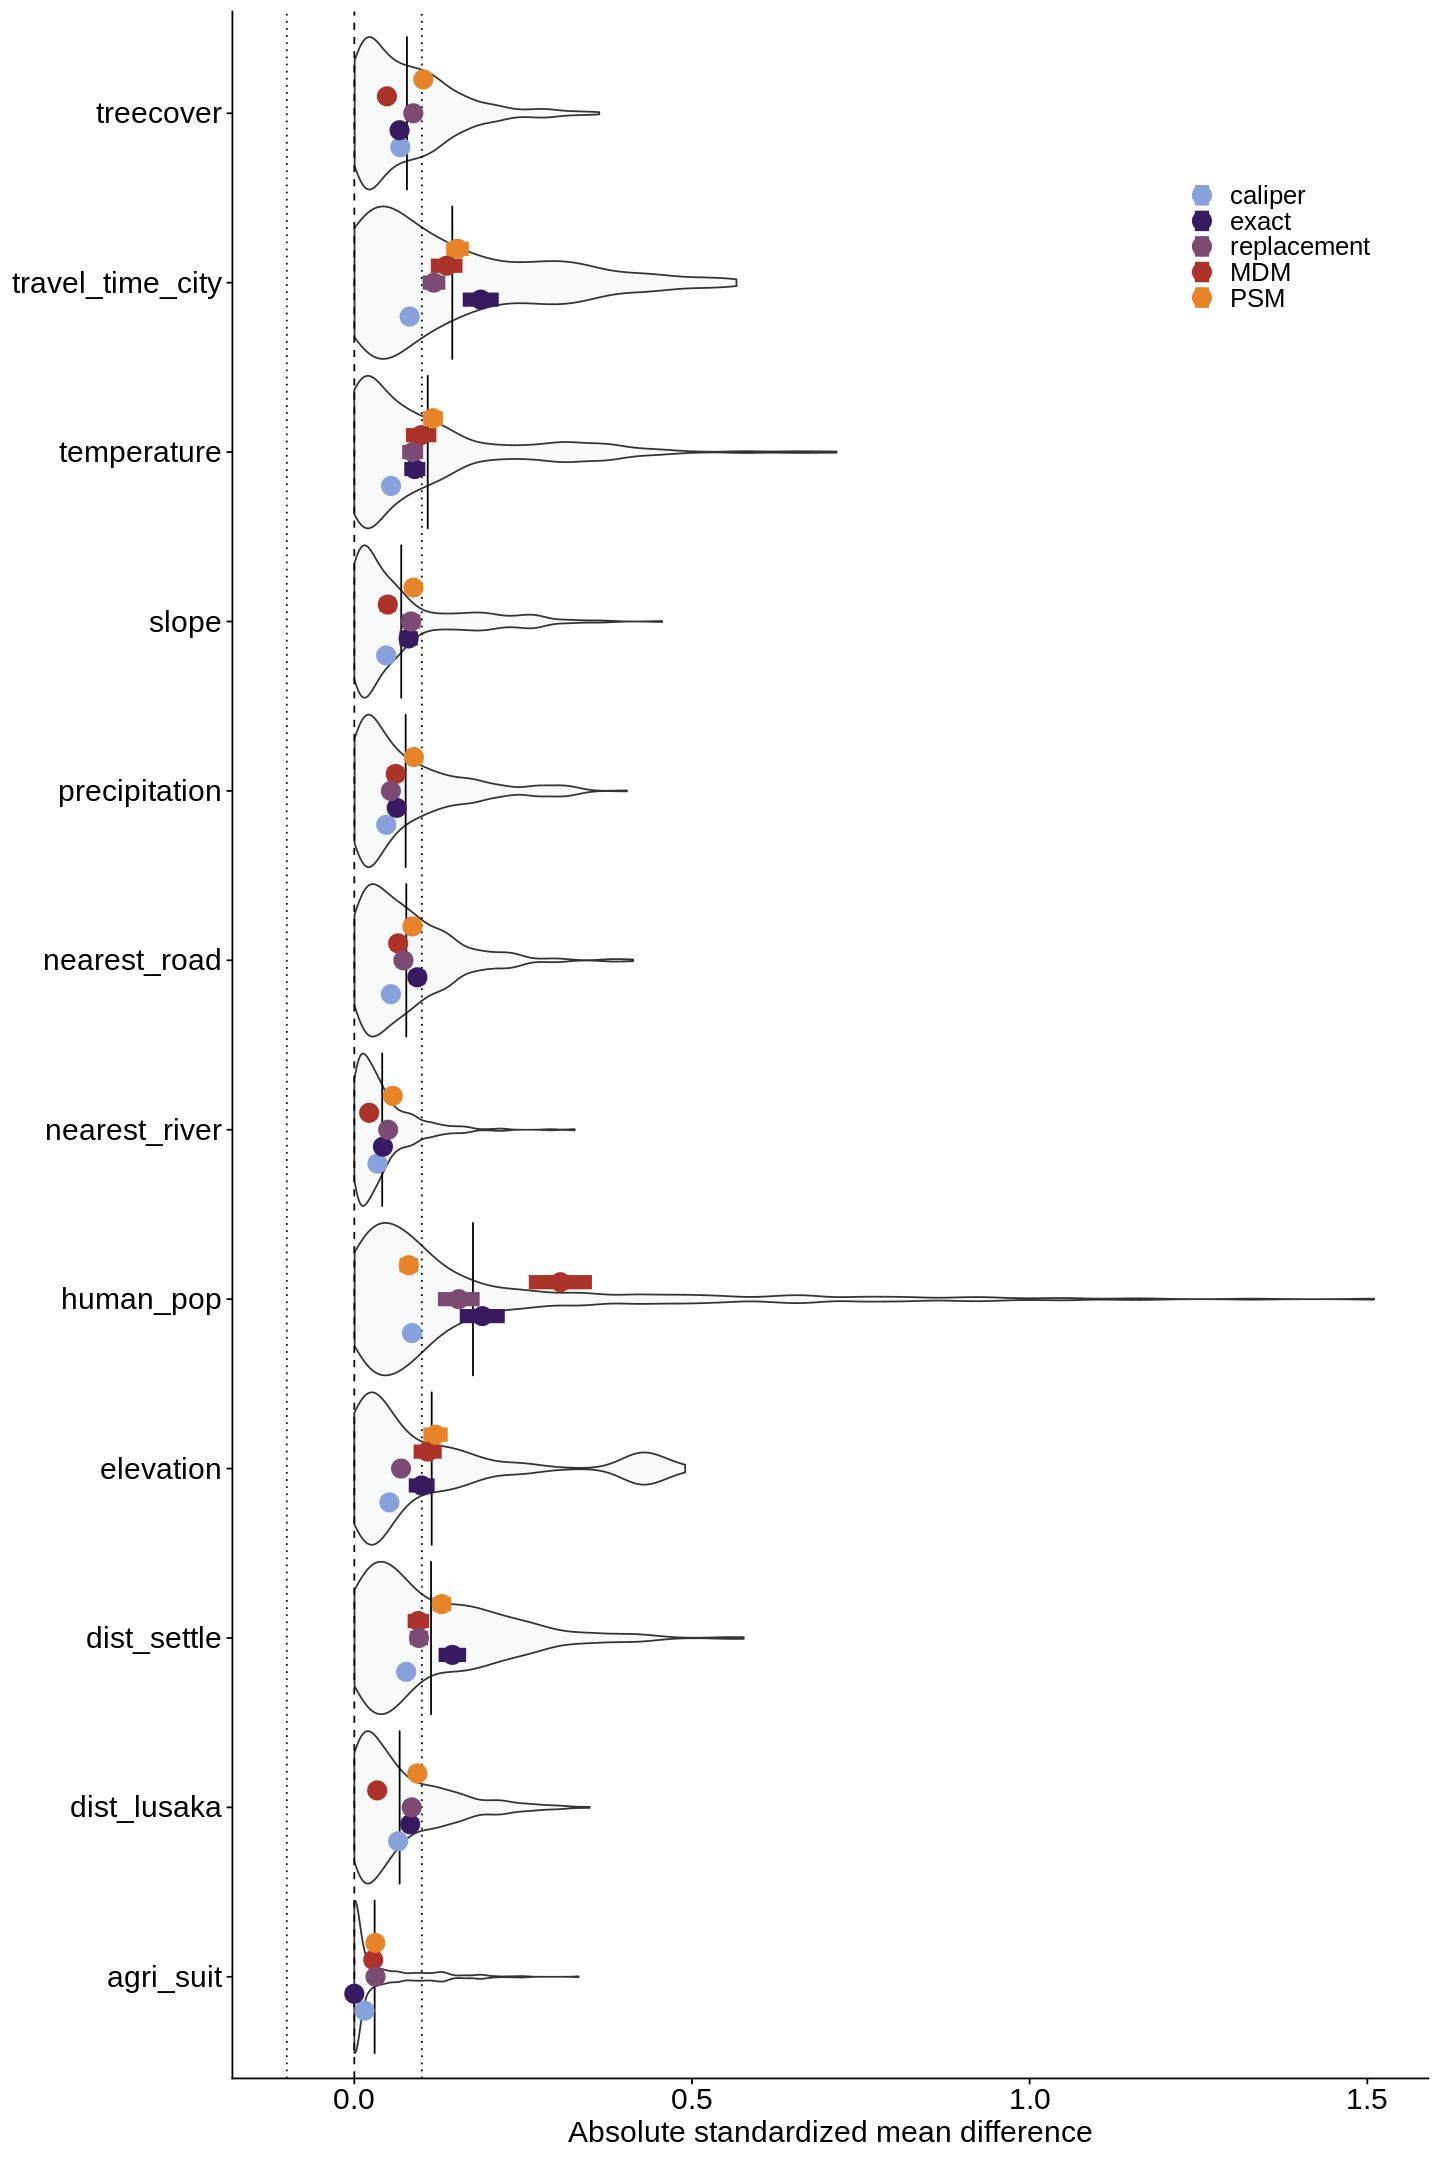

In [82]:
options(repr.plot.width=12, repr.plot.height=18)


(bal_par_plt_obs_con <-   ggplot() +
                         geom_violin(data = bal_obs_df_con, aes(abs_smd, confounder), fill = '#F8F9F9', scale = 'width') +
                         geom_violin(data = bal_df_mean_con, aes(abs_smd, confounder), colour = 'black', scale = 'width') +
                         #geom_point(data = filter(smd_df2, dataset == 'Unmatched'), aes(x = smd, metric2, shape = dataset),  colour = 'black', size = 3, stroke = 1.2) +
                         scale_shape_manual(values = c('Unmatched'=8)) +  
                         geom_vline(xintercept = 0,linetype = 'dashed') + 
                         geom_vline(xintercept = 0.1, linetype = 'dotted') +
                         geom_vline(xintercept = -0.1, linetype = 'dotted') +
 
                         geom_linerange(data = bal_obs_long_con, aes(xmin = lo_ci, xmax= up_ci,
                                                                   y = confounder, colour = parameter), size = 4,
                                    position = position_dodge(width =0.5)) +
                         geom_point(data = bal_obs_long_con, aes(x = mean_smd,
                                                                   y = confounder, colour = parameter), size = 5,
                                    position = position_dodge(width =0.5)) +
 
                         theme_cowplot() +
                         scale_colour_manual(values = c(pal[1],pal[2],pal[3],pal[5], pal[6])) +
                         labs(x='Absolute standardized mean difference') +
                         theme(text = element_text(size = 18),  
                                 axis.title.y =element_blank(), 
                                 axis.text=element_text(size = 18),
                                 legend.position = c(0.8, 0.89), legend.title = element_blank())

 )

In [83]:
ggsave(bal_par_plt_obs_con, 'png', filename = 'figures/bal_par_plt_obs_con.png', width = 13.5, height = 16)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


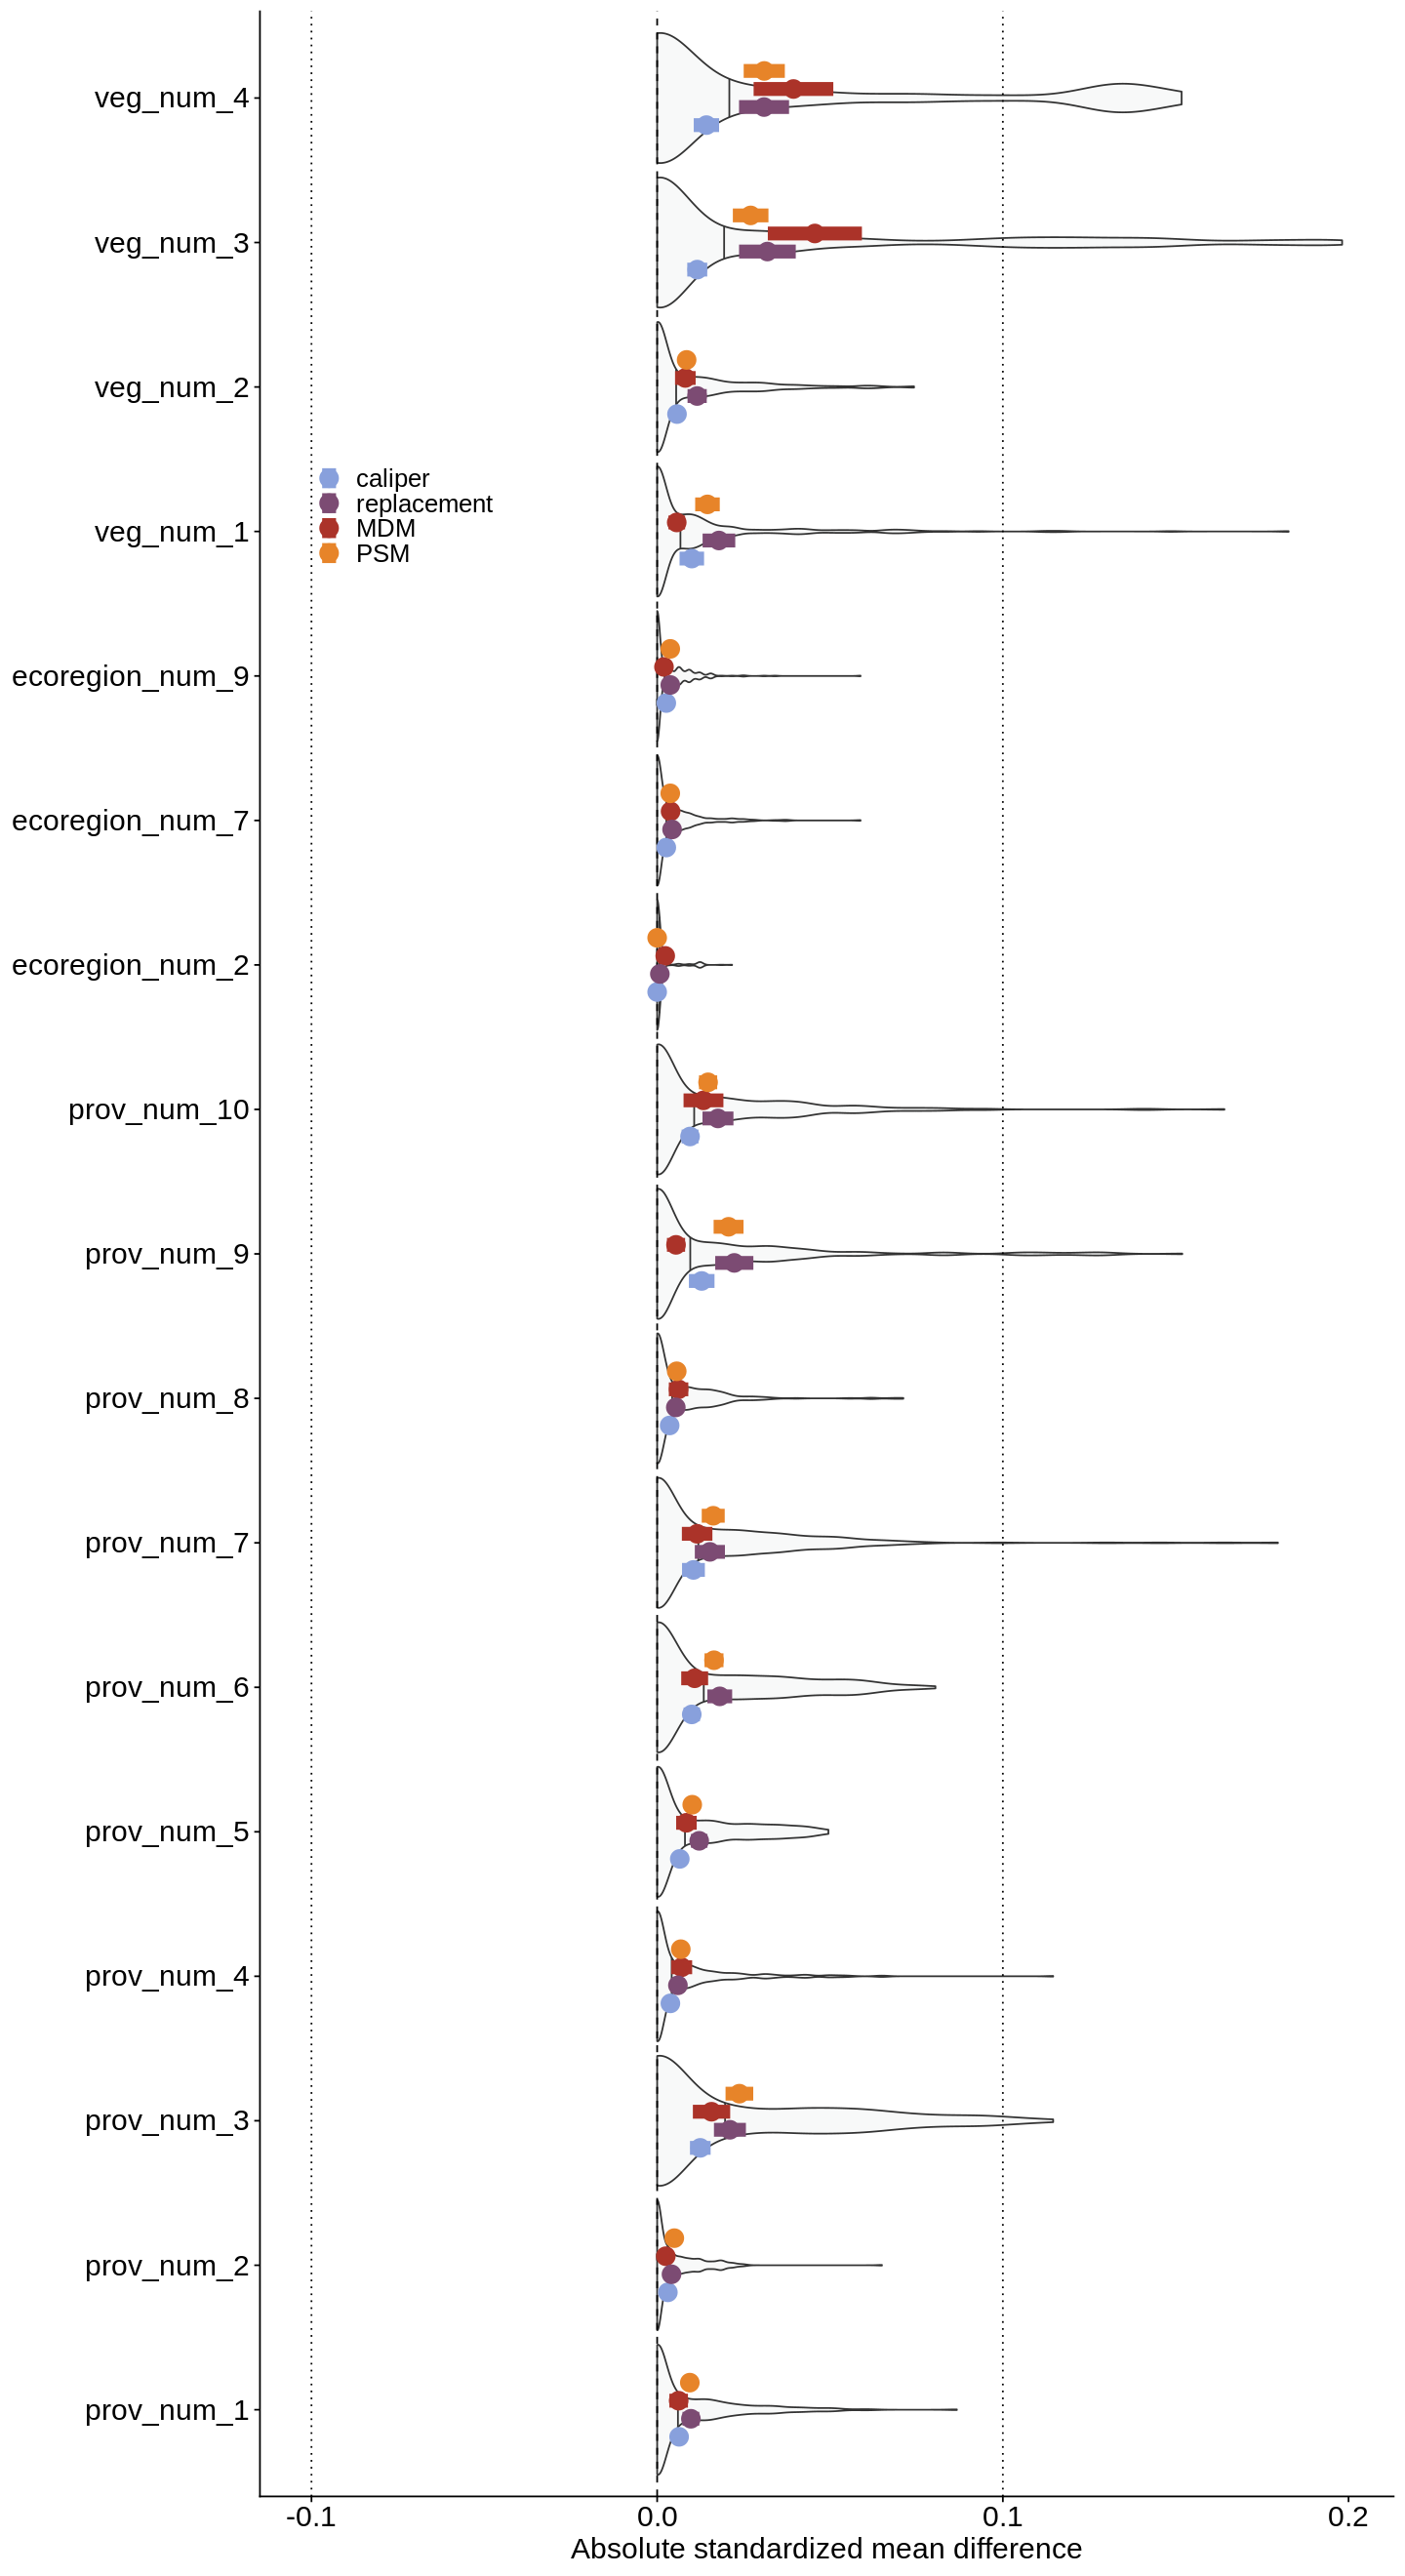

In [84]:
options(repr.plot.width=12, repr.plot.height=22)


(bal_par_plt_obs_cat <-   ggplot() +
                         geom_violin(data = bal_obs_df_cat, aes(abs_smd, confounder), draw_quantiles = 0.5, fill = '#F8F9F9', scale = 'width') +
                         #geom_point(data = filter(smd_df2, dataset == 'Unmatched'), aes(x = smd, metric2, shape = dataset),  colour = 'black', size = 3, stroke = 1.2) +
                         scale_shape_manual(values = c('Unmatched'=8)) +  
                         geom_vline(xintercept = 0,linetype = 'dashed') + 
                         geom_vline(xintercept = 0.1, linetype = 'dotted') +
                         geom_vline(xintercept = -0.1, linetype = 'dotted') +
 
                         geom_linerange(data = bal_obs_long_cat, aes(xmin = lo_ci, xmax= up_ci, y = confounder, colour = parameter), size = 4,
                                    position = position_dodge(width =0.5)) +
 
                         geom_point(data = bal_obs_long_cat, aes(x = mean_smd, y = confounder, colour = parameter), size = 5,
                                    position = position_dodge(width =0.5)) +
 
                         theme_cowplot() +
                         scale_colour_manual(values = c(pal[1],pal[3],pal[5], pal[6])) +
                         labs(x='Absolute standardized mean difference') +
                         theme(text = element_text(size = 18),  
                                 axis.title.y =element_blank(), 
                                 axis.text=element_text(size = 18),
                                 legend.position = c(0.05, 0.8), legend.title = element_blank())

 )

In [85]:
ggsave(bal_par_plt_obs_cat, 'png', filename = 'figures/bal_par_plt_obs_cat.png', width = 13.5, height = 16)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


# senesitvity testing - rerun analysis at plot level

In [86]:
##read in the plots and stems from ILUAii data
plots <- read_csv(paste0(path,'iluaii/plots.csv'), show_col_types = FALSE)
stems <- read_csv(paste0(path,'iluaii/stems.csv'), show_col_types = FALSE)

In [87]:
##read in match data 
psm <- read_csv('data/PSM_matched_data_plot_level.csv', show_col_types = FALSE) %>% mutate(dataset = 'PSM_clpr')
psm2 <- read_csv('data/PSM_no_clpr_matched_data_plot_level.csv', show_col_types = FALSE) %>% mutate(dataset = 'PSM')
mdm <- read_csv('data/MDM_matched_data_plot_level.csv', show_col_types = FALSE) %>% mutate(dataset = 'MDM_clpr')
mdm2 <- read_csv('data/MDM_no_clpr_matched_data_plot_level.csv', show_col_types = FALSE) %>% mutate(dataset = 'MDM')
unm <- read_csv('data/unmatched_data_plots.csv', show_col_types = FALSE) %>% mutate(dataset = 'Unmatched') %>% 
            drop_na() 

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1



In [88]:
table(unm$treatment)


   0    1 
2489 1384 

In [89]:
##create 1000 random datasets for comparrison

randoms <- data.frame()

set.seed(123) 

for (i in 1:1000) {
        j = runif(1, 138, 1384) #randomly select the nubmer of matched pairs max is total nubmer of treated min is > 10% of max
        df <- unm %>% 
                    group_by(treatment) %>% 
                    sample_n(j) %>%
                    mutate(subclass = seq(1:j)) %>%
                    ungroup() %>% mutate(dataset = paste0('dataset',i))
        randoms <- bind_rows(randoms, df)
}

In [90]:
##calculate plot measures
plots2 <- plots %>% 
                mutate(stocking_ha = n_stems / plot_area) %>%
                select(plot_id, stocking_ha, ba_ha, diam_mean) %>%
                mutate(across(everything(), ~replace(., is.na(.), 0))) 

In [91]:
##select only distinct trees from the stems dataset - aovids inflated abudances
trees <- stems %>%
            select(plot_id, tree_id, species_name_clean) %>%
            distinct(tree_id, .keep_all = TRUE)

In [92]:
##make a community matrix
sp_mat <- plots %>%
            select(plot_id) %>%
            left_join(trees, by = 'plot_id') %>%
            group_by(plot_id, species_name_clean) %>%
            summarize(count = n()) %>%
            ungroup() %>%
            pivot_wider(names_from = 'species_name_clean', values_from = 'count') %>%
            mutate(across(everything(), ~replace(., is.na(.), 0))) %>%
            column_to_rownames(var = "plot_id") %>%
            select(-'NA')

`summarise()` has grouped output by 'plot_id'. You can override using the `.groups` argument.



In [93]:
##calcualte shannon index
shannon <- diversity(sp_mat, index = "shannon") 

In [94]:
##calcuate richenss as sum of species
richness <- sp_mat %>% 
            rownames_to_column(var = "plot_id") %>%
            mutate(across(where(is.numeric), ~replace(., . > 0, 1))) %>%
            transmute(plot_id, richness = rowSums(across(where(is.numeric)))) 

In [95]:
##convert to dataframes
shannon_df <- as.data.frame(shannon) %>% 
                rownames_to_column(var = "plot_id")

In [96]:
##calculate plot measures of species at the cluster scale
pm_sp <- richness %>%
            left_join(shannon_df, by = 'plot_id')

In [97]:
#read in table of high vlaue tree species from Zambia
hv_trees <- read_csv('data/high_value_trees.csv', show_col_types = FALSE)

In [98]:
##filter to jsut those with an extractive use - timber of charcol
hv_extract <- hv_trees %>% 
                filter(str_detect(Major_use, c('Timber','Charcoal')))

In [99]:
##as a list
hve_sp <- hv_extract$Species

In [100]:
##number of high vlaue extractive speceis in a plot
pm_hve_sp <- trees %>%
                filter(species_name_clean %in% hve_sp) %>%
                left_join(select(plots, plot_id), by = 'plot_id') %>%
                group_by(plot_id) %>%
                summarize(hve_sp = length(species_name_clean))

In [101]:
##join all plot measurments together
pm <- plots2 %>% 
            left_join(pm_sp, by = 'plot_id') %>%
            left_join(pm_hve_sp, by = 'plot_id') %>%
            mutate(hve_sp = ifelse(is.na(hve_sp), 0, hve_sp)) 

In [102]:
##mean standerize the plot measurements so mean = 0
pm_stand <- pm %>%
             mutate(across(.cols = stocking_ha:hve_sp, ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)))

In [103]:
##plot distrubtion of plot measurments in treamaent and control
pm_long <- unm %>% 
            select(plot_id, treatment) %>%
            left_join(pm_stand, by = 'plot_id') %>%
            pivot_longer(stocking_ha:hve_sp, names_to = 'var', values_to = 'value') %>%
            mutate(treatment = as.factor(treatment))

# How balanced are the matched datasets using plot measurements?

In [104]:
all_pm <-bind_rows(psm, psm2, mdm, mdm2, unm) %>%
            select(dataset, plot_id, treatment, subclass) %>%
            left_join(pm, by = 'plot_id') 

In [105]:
all_pms <-bind_rows(psm, psm2, mdm, mdm2, unm) %>%
            select(dataset, plot_id, treatment, subclass) %>%
            left_join(pm_stand, by = 'plot_id') 

In [106]:
#estamte the sd for treated units (what MathcIT uses as standerization factor for ATT - the default)
metrics = unique(pm_long$var)

trt_sd <- all_pm %>% 
            filter(dataset == 'Unmatched' & treatment == 1) %>% 
                select(all_of(metrics)) %>% 
                    summarize(across(all_of(metrics), ~sd(.x))) %>%
                        pivot_longer(cols = everything(), names_to = 'metric', values_to = 'trt_sd')

In [107]:
##what is the smd for unobervered covarites for each dataset
metrics = unique(pm_long$var)
datasets = unique(all_pm$dataset)

smd_df <- data.frame()

for(i in 1:length(datasets)) {

    data <-  all_pm %>% filter(dataset == datasets[i]) %>%
                              select(treatment, all_of(metrics))
        
        
        ##calcauite SMD for each conf in each dataset
        smd <- data %>%
                 group_by(treatment) %>%
                 summarize(across(all_of(metrics), list(mean = mean, var = var),.names = "{.col}-{.fn}")) %>%
                 ungroup() %>%
                 summarize(across(.cols = ends_with('mean'), ~ (last(.x) - first(.x))), 
                           across(.cols = ends_with('var'), ~ (last(.x)/first(.x)))) %>%
                 pivot_longer(cols =  everything(), names_to = c('metric', 'measure'),  names_sep= "-", values_to = 'value') %>%

                 pivot_wider(names_from = 'measure', values_from = 'value') %>%
                 rename('mean_dif' = 'mean', 'var_ratio' = 'var') %>%
                 left_join(trt_sd, by = 'metric') %>%
                 mutate(smd = mean_dif / trt_sd, abs_smd = abs(mean_dif) / trt_sd, dataset = datasets[i]) 
        
     smd_mean <- smd %>% 
                      group_by(dataset) %>%
                      summarize(metric = 'mean', across(mean_dif:abs_smd, mean)) %>%
                      select(metric:abs_smd, dataset)  
        
     smd_df = bind_rows(smd_df, smd, smd_mean)
    
     }   

In [108]:
##order the metrics for plotsing
smd_df2 <- smd_df %>%
            mutate(metric2 = factor(metric, ordered = TRUE, levels = c('mean', 'richness', 'shannon', 'hve_sp', 'ba_ha', 'diam_mean', 'stocking_ha')))

In [109]:
## calcualte SMD for plot measurments for the randomly generated datasets
smd_ran <- randoms %>%
                select(plot_id, dataset, treatment) %>%
                    left_join(pm, by = 'plot_id') %>%
                        group_by(dataset, treatment) %>%
                         summarize(across(all_of(metrics), list(mean = mean, var = var),.names = "{.col}-{.fn}")) %>%
                            ungroup() %>%
                             group_by(dataset) %>%
                              summarize(across(.cols = ends_with('mean'), ~ (last(.x) - first(.x))), 
                                         across(.cols = ends_with('var'), ~ (last(.x)/first(.x)))) %>%
                              pivot_longer(cols =  !dataset, names_to = c('metric', 'measure'),  names_sep= "-", values_to = 'value') %>%

                              pivot_wider(names_from = 'measure', values_from = 'value') %>%
                              rename('mean_dif' = 'mean', 'var_ratio' = 'var') %>%

                                 left_join(trt_sd, by = c('metric')) %>%
                                    mutate(smd = mean_dif / trt_sd, abs_smd = abs(mean_dif) / trt_sd)

smd_mean_ran <- smd_ran %>% 
                      group_by(dataset) %>%
                      summarize(metric = 'mean', across(mean_dif:abs_smd, mean))


smd_ran2 <- bind_rows(smd_mean_ran, smd_ran) %>%
            mutate(metric2 = factor(metric, ordered = TRUE, levels = c('mean', 'richness', 'shannon', 'hve_sp', 'ba_ha', 'diam_mean', 'stocking_ha')))

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.



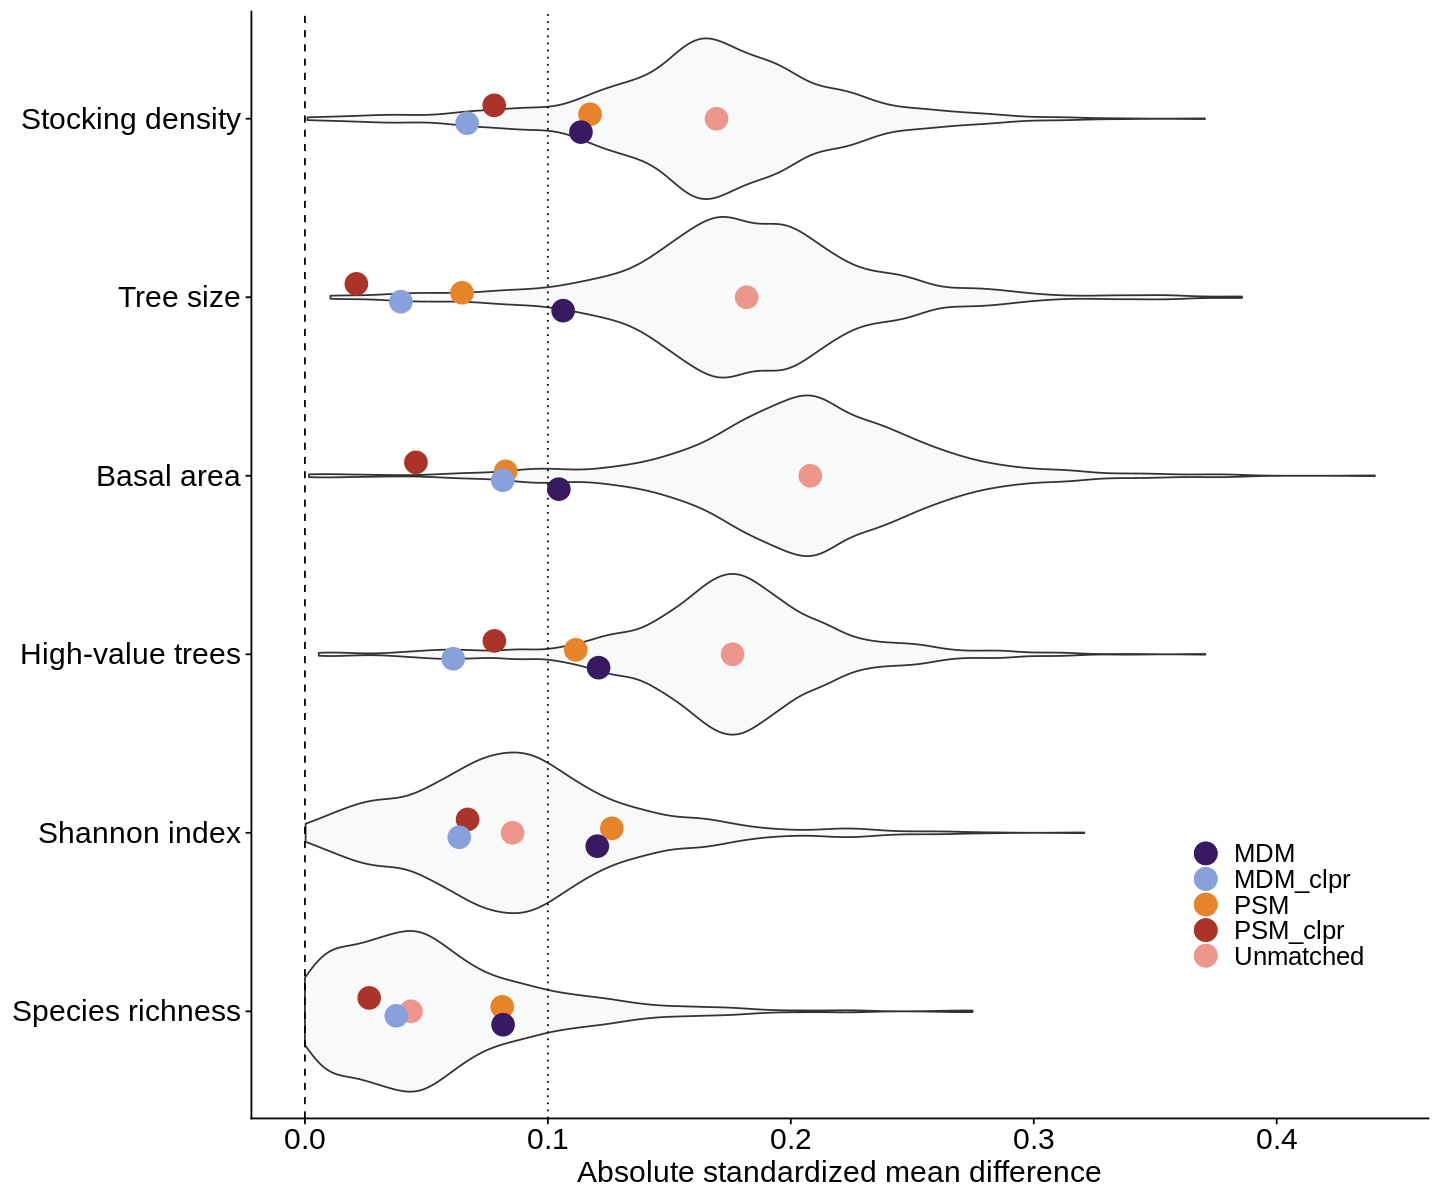

In [110]:
##produce plot of smds for all match years 
##plot ofthe smd for each confounder before and after the match, the 'distacne' measure is the propensity score
options(repr.plot.width=12, repr.plot.height=10)

(smd_plot <- ggplot() + 
            geom_violin(data = filter(smd_ran2, metric2 != 'mean'), aes(abs_smd, metric2), fill = '#F8F9F9', scale = 'width') +
            geom_vline(xintercept = 0, linetype = 'dashed') + 
            geom_vline(xintercept = 0.1, linetype = 'dotted') +

            geom_point(data = filter(smd_df2, dataset == 'Unmatched' & metric2 != 'mean'), aes(x = abs_smd, metric2,  colour = dataset), stroke = 2, size = 4) +
            geom_point(data = filter(smd_df2, dataset != 'Unmatched'& metric2 != 'mean'), aes(x = abs_smd, metric2, colour = dataset), stroke = 2, size = 4,
                       position = position_dodge(width = 0.2)) +
            theme_cowplot() +
            scale_colour_manual(values = c(pal[2], pal[1], pal[6], pal[5], pal[4])) +
            scale_y_discrete(labels = c('Species richness', 'Shannon index', 'High-value trees', 
                                        'Basal area', 'Tree size', 'Stocking density')) +
            labs(x='Absolute standardized mean difference') +
            theme(text = element_text(size = 18),  
                     axis.title.y =element_blank(), 
                     axis.text=element_text(size = 18),
                     legend.position = c(0.8, 0.2), legend.title = element_blank())
)


In [111]:
ggsave(smd_plot, 'png', filename = 'figures/smd_plot_unob_plot_level.png', width = 12, height = 10)